# Hyperparameter Tuning for NLP Models

This notebook focuses on the hyperparameter tuning of three different transformer-based models to optimize their performance on two types of classification tasks:
1. **Boolean Classification**: Determining if a statement exhibits bias ('Bias' or 'No Bias').
2. **Multiclass Classification**: Identifying the type of bias present in a statement ('Centre', 'Left', or 'Right').

We will be using the BABE dataset, which contains annotated statements classified according to the presence and type of bias.

## Models Used
- **RoBERTa**: A robustly optimized BERT approach that modifies key hyperparameters in BERT and removes the next-sentence pretraining objective.
- **DistilBERT**: A distilled version of BERT that retains most of the performance of BERT but with fewer parameters and faster inference time.
- **XLM-RoBERTa**: A multilingual model trained on 100 different languages, suitable for cross-lingual transfer learning.

## Objectives
- Identify the best hyperparameters for each model on the boolean classification task.
- Re-tune the models for multiclass classification on bias type.
- Compare the performance across models and classification tasks to determine the most effective model configuration.

Each section of the notebook will guide you through the process of data preparation, model configuration, hyperparameter tuning, and evaluation of results.


## Imports, libraries and rusable functions

In [3]:
# Standard Library Imports
import os
import re
import time
import ast
import warnings
import math
import copy
import json
from collections import Counter
from typing import List, Tuple

# Data Handling
import pandas as pd
import numpy as np
import csv

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt  # If used, uncomment this line

# Machine Learning: Model Preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Machine Learning: Models and Frameworks
import xgboost
from xgboost import plot_importance  # Uncomment if xgboost importance plot is required
import tensorflow as tf
import torch

# Transformers and NLP
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DistilBertConfig, DistilBertModel, DistilBertForSequenceClassification,
    XLMRobertaForSequenceClassification, CamembertForSequenceClassification,
    RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup,
    Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback
)
from datasets import load_dataset, DatasetDict, Dataset

# Utilities
from tqdm.notebook import tqdm
import wandb
import optuna


In [4]:
def ensemble_score(output1, output2, output3, true_labels: List[int]) -> Tuple[List[int], float]:
    """
    Compute the final labels by majority voting from three model predictions.
    
    Args:
    output1, output2, output3: Model outputs with an attribute `predictions` which should be numpy arrays.
    true_labels (List[int]): The list of true labels for evaluation.
    
    Returns:
    Tuple[List[int], float]: A tuple containing the list of predicted labels and the accuracy score.
    """
    final_labels = []
    
    for pred1, pred2, pred3 in zip(output1.predictions, output2.predictions, output3.predictions):
        label1 = np.argmax(pred1)
        label2 = np.argmax(pred2)
        label3 = np.argmax(pred3)
        labels = [label1, label2, label3]
        # Handling ties by selecting the label of the first model
        if labels.count(label1) > 1:
            final_labels.append(label1)
        elif labels.count(label2) > 1:
            final_labels.append(label2)
        else:
            final_labels.append(label3)
        
    acc = accuracy_score(true_labels, final_labels)
    return final_labels, acc


def ensemble_score_total_sum(output1, output2, output3, true_labels: List[int], use_softmax: bool = False) -> Tuple[List[int], float]:
    """
    Compute the final labels by summing the predictions from three models and selecting the maximum.
    
    Args:
    output1, output2, output3: Model outputs with an attribute `predictions` which should be numpy arrays.
    true_labels (List[int]): The list of true labels for evaluation.
    use_softmax (bool): Apply softmax to predictions before summing if predictions are logits.
    
    Returns:
    Tuple[List[int], float]: A tuple containing the list of predicted labels and the accuracy score.
    """
    final_labels = []
    
    for pred1, pred2, pred3 in zip(output1.predictions, output2.predictions, output3.predictions):
        if use_softmax:
            pred1 = softmax(pred1)
            pred2 = softmax(pred2)
            pred3 = softmax(pred3)
        pred_total = pred1 + pred2 + pred3
        final_labels.append(np.argmax(pred_total))
        
    acc = accuracy_score(true_labels, final_labels)
    return final_labels, acc

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
    # will call on_log on each logging step, specified by TrainerArguement. (i.e TrainerArguement.logginng_step)
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}

def compute_multiclass_metrics(eval_pred):
    """
    Compute various evaluation metrics for multiclass classification.
    
    Args:
        eval_pred (tuple): A tuple containing model logits and ground-truth labels.
        
    Returns:
        dict: A dictionary containing accuracy, precision, recall, f1-score, and optionally a confusion matrix.
    """
    logits, labels = eval_pred
    if logits.shape[1] == 1:  # Binary classification fallback
        predictions = logits.round()
        accuracy = lambda p: {'accuracy': (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
    else:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(labels, predictions)

    # Calculate metrics
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)

    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Calculate custom performance metric
    cust_performance = 0.5 * accuracy + 0.5 * f1
    
    return {
        "eval_accuracy": accuracy,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
        "eval_cust_performance":cust_performance,
        #"eval_confusion_matrix": conf_matrix.tolist()  # Convert to list for JSON serializability if needed
    }

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GPU: NVIDIA GeForce RTX 4070 Ti SUPER is available.
cuda


## Data Preparation

Before we can begin tuning our models, we need to prepare our dataset:

- **Dataset Loading**: Load the BABE dataset.
- **Preprocessing**: Preprocess the text data to fit the input requirements of transformer models. This includes tokenization and encoding the statements.
- **Dataset Splitting**: Split the dataset into training, validation, and testing subsets to ensure robust evaluation.

This section will leverage Hugging Face's `datasets` and `transformers` libraries for efficient data handling and preprocessing.


In [6]:
data = pd.read_excel('data/final_labels_SG1.xlsx')
data2 = pd.read_excel('data/final_labels_SG2.xlsx')
data = pd.concat([data,data2])
data.label_opinion.value_counts()

label_opinion
Entirely factual                         2239
Somewhat factual but also opinionated    1453
Expresses writer’s opinion               1283
No agreement                              399
Name: count, dtype: int64

In [7]:
data.groupby('type').label_bias.value_counts()
data[(data.label_bias == 'Biased') & (data.type == 'center')].head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
5,A review of his posts in online message boards...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,white-nationalism,center,Biased,Entirely factual,['plant']
14,Like many Americans also crippled by student l...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,student-debt,center,Biased,Somewhat factual but also opinionated,['crippled']
32,The ADL report represents a sobering warning a...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,white-nationalism,center,Biased,No agreement,['sobering']
34,The 2010s saw the U.S. economy achieve its lon...,https://www.reuters.com/article/us-usa-economy...,reuters,student-debt,center,Biased,Somewhat factual but also opinionated,['bragging']
43,A push by Virginia Democrats to loosen restric...,https://eu.usatoday.com/story/news/politics/20...,usa-today,abortion,center,Biased,Somewhat factual but also opinionated,['clash']


In [8]:
def custom_label(x):
    if x['type'] == 'center' or x.label_bias == 'Non-biased':
        return 'Non-biased'
    else:
        return x['type'] + '-' + 'Biased'
print(data.columns)

Index(['text', 'news_link', 'outlet', 'topic', 'type', 'label_bias',
       'label_opinion', 'biased_words'],
      dtype='object')


In [9]:
data.type.value_counts()

type
right     1684
left      1683
center    1007
Name: count, dtype: int64

In [10]:
data = data.dropna(subset=['type'])
data['new_label'] = data.apply(lambda x: custom_label(x), axis = 1)
data.new_label.value_counts()

new_label
Non-biased      2312
right-Biased    1046
left-Biased     1016
Name: count, dtype: int64

In [11]:
data = data[data.label_bias != 'No agreement']
data = data[['text','new_label']]
data.new_label[data.new_label == 'Non-biased'] = 0
data.new_label[data.new_label == 'left-Biased'] = 1
data.new_label[data.new_label == 'right-Biased'] = 2

In [12]:
# Step 1: Split data into test and temporary train data
train_temp_data, test_multiclass_data = train_test_split(data, test_size=0.10, random_state=42, stratify=data['new_label'])

# Step 2: Split the remaining data into train and validation sets
train_multiclass_data, val_multiclass_data = train_test_split(train_temp_data, test_size=1/9, random_state=42, stratify=train_temp_data['new_label'])  # 1/9 is 10% of the remaining 90%


In [13]:
train_multiclass_data

,text,new_label
878,Democratic presidential candidate Beto O’Rourk...,0
1593,As the COVID-19 virus spreads in the USA and a...,0
1778,Mulvaney apparently didn’t see this line of in...,1
1137,Haqqani claimed the Taliban are just looking f...,2
438,"At least Morrissey, who stepped into his son’s...",2
...,...,...
1025,"For decades, Democratic administrations have b...",1
843,Despite achieving a historic position of leade...,0
726,Climate Wunderkind Greta Thunberg has garnered...,2
1635,The American middle class is falling deeper in...,0


In [14]:
# Check distributions to confirm stratification worked as expected
print("Training data distribution:\n", train_multiclass_data['new_label'].value_counts(normalize=True))
print("Validation data distribution:\n", val_multiclass_data['new_label'].value_counts(normalize=True))
print("Test data distribution:\n", test_multiclass_data['new_label'].value_counts(normalize=True))

Training data distribution:
 new_label
0    0.544000
2    0.231111
1    0.224889
Name: proportion, dtype: float64
Validation data distribution:
 new_label
0    0.545024
2    0.229858
1    0.225118
Name: proportion, dtype: float64
Test data distribution:
 new_label
0    0.545024
2    0.229858
1    0.225118
Name: proportion, dtype: float64


In [15]:
# Convert to Dataset
BABE_multiclass_Dataset = DatasetDict(
    train=Dataset.from_pandas(train_multiclass_data,preserve_index=False),
    val=Dataset.from_pandas(val_multiclass_data,preserve_index = False),
    test=Dataset.from_pandas(test_multiclass_data,preserve_index=False)
)
BABE_multiclass_Dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'new_label'],
        num_rows: 3375
    })
    val: Dataset({
        features: ['text', 'new_label'],
        num_rows: 422
    })
    test: Dataset({
        features: ['text', 'new_label'],
        num_rows: 422
    })
})

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

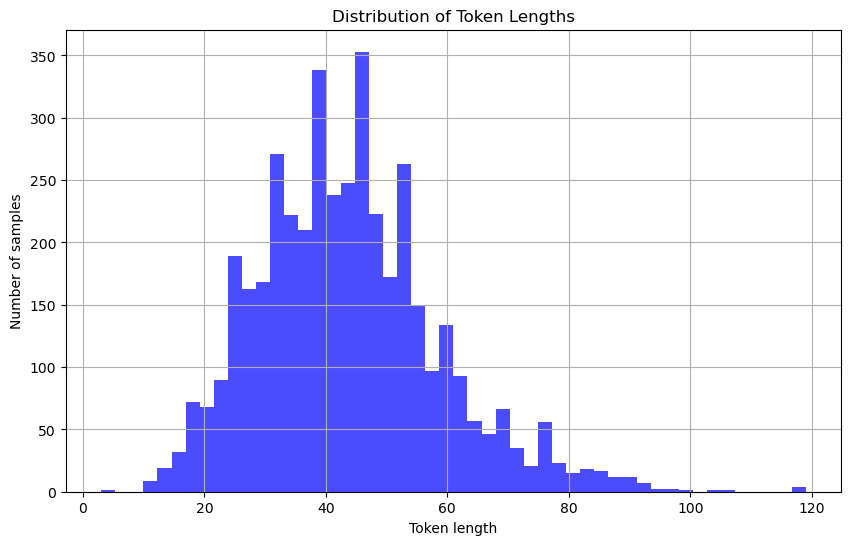

count    4219.000000
mean       43.716758
std        14.991182
min         3.000000
25%        33.000000
50%        43.000000
75%        52.000000
max       119.000000
dtype: float64
DatasetDict({
    train: Dataset({
        features: ['text', 'new_label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3375
    })
    val: Dataset({
        features: ['text', 'new_label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 422
    })
    test: Dataset({
        features: ['text', 'new_label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 422
    })
})


In [16]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Convert pandas dataframes to Hugging Face dataset format and tokenize
train_dataset = Dataset.from_pandas(train_multiclass_data)
val_dataset = Dataset.from_pandas(val_multiclass_data)
test_dataset = Dataset.from_pandas(test_multiclass_data)
tokenized_datasets = DatasetDict({
    'train': train_dataset.map(tokenize_function, batched=True),
    'val': val_dataset.map(tokenize_function, batched=True),
    'test': test_dataset.map(tokenize_function, batched=True)
})

# Analyze token lengths to decide on an appropriate max_length
token_lengths = [len(tokenizer.encode(text)) for text in data['text']]
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token length')
plt.ylabel('Number of samples')
plt.grid(True)
plt.show()

# Print descriptive statistics of token lengths
print(pd.Series(token_lengths).describe())

# Output the tokenized datasets
print(tokenized_datasets)

In [17]:
# Load data
data = pd.read_excel('data/final_labels_SG1.xlsx')
data2 = pd.read_excel('data/final_labels_SG2.xlsx')
data = pd.concat([data, data2])
data = data[['text', 'label_bias']]
data = data[data.label_bias != 'No agreement']
data.label_bias.replace({'Non-biased': 1, 'Biased': 0}, inplace=True)

# Split data
train_temp_data, test_binarylabel_data = train_test_split(data, test_size=0.10, random_state=42, stratify=data['label_bias'])
train_binarylabel_data, val_binarylabel_data = train_test_split(train_temp_data, test_size=1/9, random_state=42, stratify=train_temp_data['label_bias'])

# Convert to Dataset
BABE_binarylabel_Dataset = DatasetDict(
    train=Dataset.from_pandas(train_temp_data,preserve_index=False),
    val=Dataset.from_pandas(val_binarylabel_data,preserve_index = False),
    test=Dataset.from_pandas(test_binarylabel_data,preserve_index=False)
)
BABE_binarylabel_Dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_bias'],
        num_rows: 4697
    })
    val: Dataset({
        features: ['text', 'label_bias'],
        num_rows: 522
    })
    test: Dataset({
        features: ['text', 'label_bias'],
        num_rows: 522
    })
})

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4175 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

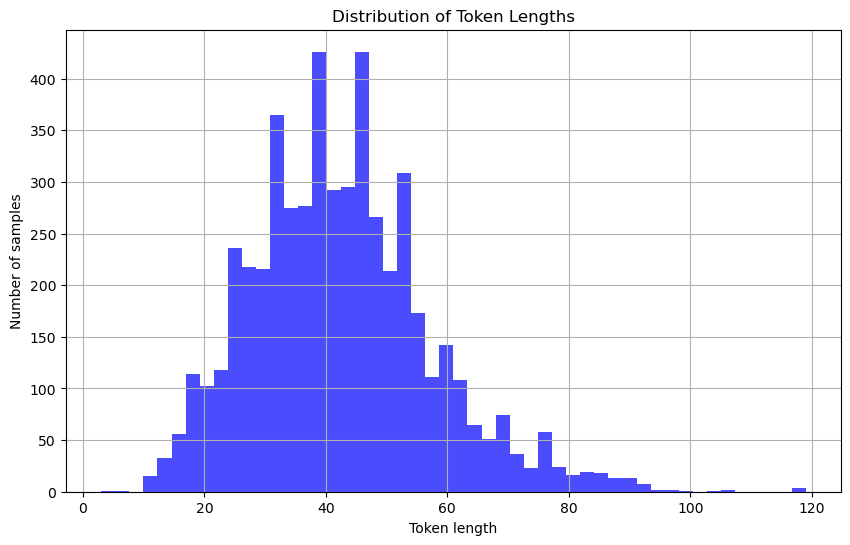

count    5219.000000
mean       42.580954
std        14.870210
min         3.000000
25%        32.000000
50%        42.000000
75%        51.000000
max       119.000000
dtype: float64
DatasetDict({
    train: Dataset({
        features: ['text', 'label_bias', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4175
    })
    val: Dataset({
        features: ['text', 'label_bias', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 522
    })
    test: Dataset({
        features: ['text', 'label_bias', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 522
    })
})


In [18]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Convert pandas dataframes to Hugging Face dataset format and tokenize
train_dataset = Dataset.from_pandas(train_binarylabel_data)
val_dataset = Dataset.from_pandas(val_binarylabel_data)
test_dataset = Dataset.from_pandas(test_binarylabel_data)
tokenized_datasets = DatasetDict({
    'train': train_dataset.map(tokenize_function, batched=True),
    'val': val_dataset.map(tokenize_function, batched=True),
    'test': test_dataset.map(tokenize_function, batched=True)
})

# Analyze token lengths to decide on an appropriate max_length
token_lengths = [len(tokenizer.encode(text)) for text in data['text']]
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token length')
plt.ylabel('Number of samples')
plt.grid(True)
plt.show()

# Print descriptive statistics of token lengths
print(pd.Series(token_lengths).describe())

# Output the tokenized datasets
print(tokenized_datasets)

## Hyperparameter Tuning

Hyperparameter tuning is crucial to optimize model performance. We will approach this by:

1. **Defining Search Space**: Identify which hyperparameters are most influential for each model and define a reasonable search space for each.
2. **Tuning Strategy**: Implement a tuning strategy using libraries like `Optuna` or `Ray Tune` that can handle the complexity and computational expense of transformer models.
3. **Evaluation Metric**: Select appropriate metrics such as F1-score, accuracy, or AUC-ROC to evaluate model performance across different hyperparameter settings.

Each model will be tuned independently to find the best settings for both classification tasks.


### 1. RoBERTa Model Tuning for Binary Classification

**Model Overview**: 
RoBERTa (Robustly Optimized BERT Approach) enhances BERT's language understanding capabilities through optimized training strategies. This includes removing BERT's next-sentence pretraining objective and training with larger mini-batches and learning rates, making it highly effective for various NLP tasks.

**Dataset Preparation**:
- **Tokenization**: We utilize RoBERTa's tokenizer with a `max_length` of 120 to ensure all texts are uniformly sized, enhancing the model's ability to learn effectively. 
- **Setup**: The dataset is processed to convert 'label_bias' into a binary 'labels' format suitable for binary classification, and data is formatted to be compatible with PyTorch.

**Hyperparameters to Tune**:
- **Learning Rate**: Suggested range is from 1e-5 to 5e-4, using a logarithmic scale to find the optimal rate efficiently.
- **Batch Size**: Tested sizes include 16, 32, and 64 to balance computational efficiency and model effectiveness.
- **Number of Epochs**: Set to 10 to allow sufficient learning without overfitting, considering the complexity of the dataset.
- **Warmup Steps**: From 0 to 500, these are crucial for stabilizing the model's early training phase.
- **Weight Decay**: Ranging from 0.01 to 0.3 to help prevent overfitting by penalizing larger weights.

**Tuning Strategy**:
- We employ Optuna, an automated hyperparameter tuning service, to systematically explore the multidimensional hyperparameter space. This approach allows us to efficiently identify the best configurations for maximizing model accuracy.

**Training Setup**:
- **Initialization**: The RoBERTa model is initialized with pretrained weights from `FacebookAI/roberta-base`, tailored for binary classification with two output labels.
- **Training**: Utilizing Hugging Face's `Trainer` API, we configure the training process according to the identified best practices and hyperparameters.
- **Evaluation**: The model's performance is continuously monitored on a validation set, and accuracy is used as the metric to determine the best model.

**Optuna Integration**:
- During the tuning process, each trial's configuration is evaluated by training the model and measuring its customer performance metric (0.5 X Accuracy + 0.5 X F1-score) on the validation set. The best parameters are reported and used to guide subsequent searches, optimizing for the highest possible customer performance metric.

This comprehensive approach ensures that the RoBERTa model is finely tuned to perform optimally on the binary classification task using the specified dataset.


In [21]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_binarylabel_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("label_bias", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="roberta-base",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

In [22]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 13:48:45,222] A new study created in memory with name: no-name-8a259b0a-82b7-4d75-984b-4b45b72c4b25
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: waldosingleton (waldosingleton-org). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.363638,0.869732,0.870681,0.869243,0.869500,0.869616
2,No log,0.555016,0.852490,0.867346,0.850564,0.850448,0.851469
3,No log,0.301104,0.886973,0.888929,0.886308,0.886670,0.886822
4,0.466500,0.210812,0.936782,0.937266,0.936501,0.936714,0.936748
5,0.466500,0.272994,0.921456,0.922806,0.920950,0.921303,0.921380
6,0.466500,0.281854,0.932950,0.933219,0.932742,0.932895,0.932922
7,0.309800,0.241213,0.934866,0.934813,0.934915,0.934851,0.934858
8,0.309800,0.218081,0.938697,0.939310,0.938381,0.938624,0.938661
9,0.309800,0.206150,0.944444,0.944945,0.944167,0.944385,0.944415
10,0.309800,0.190612,0.948276,0.949377,0.947853,0.948192,0.948234


[I 2024-05-18 13:52:26,796] Trial 0 finished with value: 0.9482339379157478 and parameters: {'learning_rate': 0.00013830210599729696, 'batch_size': 32, 'warmup_steps': 369, 'weight_decay': 0.1658197813352584}. Best is trial 0 with value: 0.9482339379157478.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.351250,0.871648,0.874409,0.870829,0.871193,0.871420
2,0.498100,0.268139,0.915709,0.918112,0.915017,0.915466,0.915587
3,0.498100,0.197380,0.942529,0.944185,0.941994,0.942407,0.942468
4,0.277200,0.144906,0.954023,0.954426,0.953786,0.953980,0.954001
5,0.277200,0.138977,0.952107,0.952624,0.951833,0.952056,0.952082
6,0.190500,0.112425,0.967433,0.967433,0.967605,0.967430,0.967431
7,0.147900,0.098190,0.959770,0.959731,0.959792,0.959758,0.959764
8,0.147900,0.104611,0.957854,0.958265,0.957619,0.957815,0.957835
9,0.123500,0.076896,0.963602,0.964424,0.963258,0.963553,0.963577
10,0.123500,0.078833,0.959770,0.960303,0.959498,0.959727,0.959749


[I 2024-05-18 13:56:31,821] Trial 1 finished with value: 0.9674314560653992 and parameters: {'learning_rate': 1.634829223283565e-05, 'batch_size': 16, 'warmup_steps': 235, 'weight_decay': 0.11668089479102343}. Best is trial 1 with value: 0.9674314560653992.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.365994,0.862069,0.863297,0.861504,0.861777,0.861923
2,No log,0.326055,0.885057,0.887697,0.884281,0.884677,0.884867
3,No log,0.195199,0.944444,0.944945,0.944167,0.944385,0.944415
4,No log,0.193656,0.948276,0.949054,0.947926,0.948207,0.948242
5,No log,0.132777,0.959770,0.961747,0.959205,0.959678,0.959724
6,No log,0.166743,0.952107,0.952624,0.951833,0.952056,0.952082
7,0.305300,0.160308,0.959770,0.960915,0.959352,0.959705,0.959738
8,0.305300,0.115017,0.963602,0.964424,0.963258,0.963553,0.963577
9,0.305300,0.110594,0.967433,0.968607,0.967017,0.967380,0.967407
10,0.305300,0.108167,0.965517,0.966508,0.965137,0.965467,0.965492


[I 2024-05-18 13:59:45,170] Trial 2 finished with value: 0.9674065535025079 and parameters: {'learning_rate': 0.00013508587392424497, 'batch_size': 64, 'warmup_steps': 131, 'weight_decay': 0.12273295468310727}. Best is trial 1 with value: 0.9674314560653992.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.527645,0.770115,0.792771,0.767387,0.764299,0.767207
2,No log,0.389454,0.823755,0.848325,0.821194,0.819730,0.821742
3,No log,0.254864,0.913793,0.920471,0.912623,0.913258,0.913526
4,No log,0.167135,0.940613,0.941369,0.940261,0.940534,0.940574
5,No log,0.131608,0.954023,0.955741,0.953492,0.953926,0.953974
6,No log,0.122033,0.963602,0.963602,0.963772,0.963598,0.963600
7,0.311700,0.088073,0.961686,0.961672,0.961672,0.961672,0.961679
8,0.311700,0.076556,0.963602,0.964761,0.963184,0.963543,0.963572
9,0.311700,0.068812,0.969349,0.970038,0.969044,0.969312,0.969330
10,0.311700,0.072053,0.965517,0.966197,0.965211,0.965476,0.965497


[I 2024-05-18 14:02:59,050] Trial 3 finished with value: 0.9693304141580004 and parameters: {'learning_rate': 2.7538190999281915e-05, 'batch_size': 64, 'warmup_steps': 181, 'weight_decay': 0.20952642452111547}. Best is trial 3 with value: 0.9693304141580004.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.617671,0.731801,0.763182,0.728398,0.721583,0.726692
2,No log,0.370896,0.837165,0.843771,0.835820,0.835946,0.836555
3,No log,0.345411,0.863985,0.887814,0.861622,0.861272,0.862628
4,No log,0.187564,0.946360,0.946424,0.946267,0.946332,0.946346
5,No log,0.165398,0.944444,0.944402,0.944461,0.944428,0.944436
6,No log,0.112348,0.967433,0.967396,0.967458,0.967423,0.967428
7,0.348900,0.086154,0.965517,0.965741,0.965358,0.965492,0.965505
8,0.348900,0.088670,0.965517,0.966508,0.965137,0.965467,0.965492
9,0.348900,0.075211,0.971264,0.971219,0.971364,0.971259,0.971262
10,0.348900,0.062427,0.967433,0.967579,0.967311,0.967413,0.967423


[I 2024-05-18 14:06:16,664] Trial 4 finished with value: 0.9712617836290803 and parameters: {'learning_rate': 4.046524513829487e-05, 'batch_size': 64, 'warmup_steps': 377, 'weight_decay': 0.05068707760392943}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.440838,0.806513,0.817196,0.804717,0.804179,0.805346
2,No log,0.285927,0.898467,0.900083,0.897879,0.898234,0.898351
3,No log,0.182795,0.940613,0.941369,0.940261,0.940534,0.940574
4,No log,0.214092,0.932950,0.933994,0.932522,0.932841,0.932896
5,No log,0.289759,0.909962,0.910919,0.909525,0.909816,0.909889
6,No log,0.222617,0.942529,0.943443,0.942141,0.942444,0.942486
7,0.348600,0.239114,0.942529,0.944185,0.941994,0.942407,0.942468
8,0.348600,0.145190,0.961686,0.961905,0.961525,0.961658,0.961672
9,0.348600,0.144005,0.961686,0.961672,0.961672,0.961672,0.961679
10,0.348600,0.148135,0.955939,0.955892,0.956033,0.955931,0.955935


[I 2024-05-18 14:09:32,905] Trial 5 finished with value: 0.9616787906367932 and parameters: {'learning_rate': 0.00019363547203842148, 'batch_size': 64, 'warmup_steps': 395, 'weight_decay': 0.039358730373196635}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.410714,0.835249,0.835808,0.834821,0.835007,0.835128
2,No log,0.296082,0.892720,0.895431,0.891947,0.892365,0.892543
3,No log,0.313342,0.898467,0.902754,0.899495,0.898333,0.898400
4,No log,0.320444,0.908046,0.915901,0.906764,0.907388,0.907717
5,No log,0.705800,0.490421,0.245211,0.500000,0.329049,0.409735
6,No log,0.698576,0.490421,0.245211,0.500000,0.329049,0.409735
7,0.502900,0.703513,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.502900,0.696533,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.502900,0.693567,0.509579,0.254789,0.500000,0.337563,0.423571
10,0.502900,0.693114,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 14:12:49,446] Trial 6 finished with value: 0.907716972567725 and parameters: {'learning_rate': 0.00032010995903718843, 'batch_size': 64, 'warmup_steps': 489, 'weight_decay': 0.0944836978016988}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initializ

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.698679,0.490421,0.245211,0.500000,0.329049,0.409735
2,No log,0.694571,0.509579,0.254789,0.500000,0.337563,0.423571
3,No log,0.694881,0.509579,0.254789,0.500000,0.337563,0.423571
4,0.685800,0.710718,0.490421,0.245211,0.500000,0.329049,0.409735
5,0.685800,0.694877,0.509579,0.254789,0.500000,0.337563,0.423571
6,0.685800,0.693212,0.490421,0.245211,0.500000,0.329049,0.409735
7,0.695500,0.694878,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.695500,0.693062,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.695500,0.692964,0.509579,0.254789,0.500000,0.337563,0.423571
10,0.695500,0.693039,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 14:16:19,356] Trial 7 finished with value: 0.42357099791897623 and parameters: {'learning_rate': 0.0003850928640367263, 'batch_size': 32, 'warmup_steps': 166, 'weight_decay': 0.10848105596530658}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.685833,0.653257,0.681309,0.656837,0.642389,0.647823
2,No log,0.455579,0.804598,0.820988,0.802397,0.801225,0.802911
3,No log,0.347583,0.856322,0.870186,0.854470,0.854463,0.855392
4,No log,0.241059,0.921456,0.922806,0.920950,0.921303,0.921380
5,No log,0.194458,0.932950,0.932905,0.932962,0.932930,0.932940
6,No log,0.140547,0.946360,0.946992,0.946047,0.946296,0.946328
7,0.387300,0.136655,0.948276,0.948733,0.948661,0.948276,0.948276
8,0.387300,0.092919,0.965517,0.965941,0.965284,0.965485,0.965501
9,0.387300,0.085464,0.957854,0.959593,0.957325,0.957765,0.957810
10,0.387300,0.086229,0.967433,0.968607,0.967017,0.967380,0.967407


[I 2024-05-18 14:19:31,565] Trial 8 finished with value: 0.9674065535025079 and parameters: {'learning_rate': 2.4233244457685143e-05, 'batch_size': 64, 'warmup_steps': 461, 'weight_decay': 0.10098172359307933}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.383460,0.852490,0.853376,0.852987,0.852477,0.852484
2,0.518200,0.264783,0.906130,0.906549,0.905839,0.906031,0.906080
3,0.518200,0.221504,0.929119,0.933075,0.928248,0.928834,0.928977
4,0.281700,0.142243,0.952107,0.953223,0.951686,0.952030,0.952068
5,0.281700,0.147691,0.952107,0.953223,0.951686,0.952030,0.952068
6,0.188800,0.133570,0.959770,0.959793,0.959719,0.959752,0.959761
7,0.142100,0.086810,0.965517,0.965595,0.965431,0.965499,0.965508
8,0.142100,0.074400,0.969349,0.969577,0.969191,0.969327,0.969338
9,0.119000,0.064538,0.967433,0.967982,0.967164,0.967398,0.967416
10,0.119000,0.066913,0.965517,0.965741,0.965358,0.965492,0.965505


[I 2024-05-18 14:23:31,786] Trial 9 finished with value: 0.96933762718672 and parameters: {'learning_rate': 1.5156450209235347e-05, 'batch_size': 16, 'warmup_steps': 323, 'weight_decay': 0.03179516713384363}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initializ

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.361479,0.844828,0.846338,0.845468,0.844781,0.844805
2,No log,0.256057,0.906130,0.908223,0.905472,0.905878,0.906004
3,No log,0.221943,0.944444,0.946812,0.943800,0.944295,0.944370
4,0.393000,0.184196,0.940613,0.942953,0.939967,0.940454,0.940533
5,0.393000,0.176153,0.944444,0.944945,0.944167,0.944385,0.944415
6,0.393000,0.144636,0.952107,0.952239,0.951980,0.952078,0.952092
7,0.168600,0.135259,0.955939,0.957454,0.955445,0.955853,0.955896
8,0.168600,0.142992,0.957854,0.959179,0.957398,0.957779,0.957817
9,0.168600,0.120071,0.955939,0.955892,0.956033,0.955931,0.955935
10,0.168600,0.127746,0.961686,0.961672,0.961672,0.961672,0.961679


[I 2024-05-18 14:30:52,702] Trial 10 finished with value: 0.9616787906367932 and parameters: {'learning_rate': 5.7464884016221896e-05, 'batch_size': 32, 'warmup_steps': 46, 'weight_decay': 0.29505601391237146}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.401396,0.840996,0.851110,0.839359,0.839340,0.840168
2,0.535000,0.301300,0.896552,0.898360,0.895926,0.896294,0.896423
3,0.535000,0.214577,0.921456,0.922806,0.920950,0.921303,0.921380
4,0.299300,0.179330,0.940613,0.941686,0.940187,0.940517,0.940565
5,0.299300,0.172431,0.944444,0.946331,0.943873,0.944317,0.944381
6,0.209800,0.118404,0.955939,0.955899,0.955959,0.955926,0.955932
7,0.162600,0.115019,0.961686,0.961729,0.961892,0.961684,0.961685
8,0.162600,0.131850,0.959770,0.960915,0.959352,0.959705,0.959738
9,0.150000,0.120497,0.955939,0.957454,0.955445,0.955853,0.955896
10,0.150000,0.108782,0.961686,0.962356,0.961378,0.961640,0.961663


[I 2024-05-18 14:34:59,699] Trial 11 finished with value: 0.9616846988028318 and parameters: {'learning_rate': 1.0488465081926001e-05, 'batch_size': 16, 'warmup_steps': 325, 'weight_decay': 0.017556628789068756}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.419566,0.848659,0.849385,0.848200,0.848414,0.848536
2,0.499200,0.287729,0.906130,0.908223,0.905472,0.905878,0.906004
3,0.499200,0.158774,0.959770,0.959793,0.959719,0.959752,0.959761
4,0.292400,0.138798,0.957854,0.957927,0.957766,0.957832,0.957843
5,0.292400,0.120677,0.961686,0.961905,0.961525,0.961658,0.961672
6,0.202300,0.124526,0.961686,0.961905,0.961525,0.961658,0.961672
7,0.143600,0.120044,0.969349,0.969392,0.969558,0.969347,0.969348
8,0.143600,0.101321,0.971264,0.971590,0.971070,0.971241,0.971252
9,0.107800,0.072169,0.971264,0.971522,0.971584,0.971264,0.971264
10,0.107800,0.066683,0.963602,0.963916,0.963405,0.963571,0.963586


Could not locate the best model at roberta-base\checkpoint-2646\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


[I 2024-05-18 14:39:06,663] Trial 12 finished with value: 0.9635864923752244 and parameters: {'learning_rate': 5.039654293178046e-05, 'batch_size': 16, 'warmup_steps': 286, 'weight_decay': 0.047256846743732}. Best is trial 4 with value: 0.9712617836290803.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initializ

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.357502,0.863985,0.864621,0.864412,0.863980,0.863982
2,0.506800,0.273516,0.911877,0.913006,0.911404,0.911721,0.911799
3,0.506800,0.161216,0.948276,0.949377,0.947853,0.948192,0.948234
4,0.293900,0.135136,0.963602,0.964142,0.963331,0.963563,0.963582
5,0.293900,0.107719,0.963602,0.963916,0.963405,0.963571,0.963586
6,0.201700,0.092272,0.973180,0.973132,0.973244,0.973174,0.973177
7,0.136800,0.063416,0.975096,0.975427,0.974903,0.975075,0.975085
8,0.136800,0.057802,0.980843,0.980813,0.980983,0.980840,0.980842
9,0.107200,0.050951,0.973180,0.973170,0.973170,0.973170,0.973175
10,0.107200,0.048563,0.973180,0.973264,0.973097,0.973166,0.973173


[I 2024-05-18 14:43:22,621] Trial 13 finished with value: 0.9808416462135388 and parameters: {'learning_rate': 3.4187713564254454e-05, 'batch_size': 16, 'warmup_steps': 387, 'weight_decay': 0.06326109114949163}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.367119,0.856322,0.856835,0.855939,0.856131,0.856227
2,0.509900,0.248059,0.900383,0.904958,0.899392,0.899907,0.900145
3,0.509900,0.275095,0.919540,0.927658,0.918262,0.918964,0.919252
4,0.303600,0.182918,0.944444,0.946812,0.943800,0.944295,0.944370
5,0.303600,0.146751,0.954023,0.954674,0.953712,0.953968,0.953996
6,0.192400,0.082113,0.977011,0.977098,0.976930,0.976999,0.977005
7,0.136300,0.076268,0.965517,0.966197,0.965211,0.965476,0.965497
8,0.136300,0.068922,0.969349,0.969577,0.969191,0.969327,0.969338
9,0.101700,0.062314,0.975096,0.975061,0.975123,0.975088,0.975092
10,0.101700,0.058603,0.967433,0.968266,0.967091,0.967390,0.967411


[I 2024-05-18 14:47:29,680] Trial 14 finished with value: 0.9770054166571704 and parameters: {'learning_rate': 3.757597709207361e-05, 'batch_size': 16, 'warmup_steps': 415, 'weight_decay': 0.06494123232697294}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.413443,0.852490,0.855311,0.853354,0.852369,0.852429
2,0.512100,0.281215,0.894636,0.900179,0.893533,0.894045,0.894340
3,0.512100,0.279415,0.904215,0.907069,0.905061,0.904146,0.904180
4,0.364800,0.236200,0.934866,0.934922,0.934769,0.934831,0.934849
5,0.364800,0.215033,0.936782,0.937527,0.936428,0.936698,0.936740
6,0.258700,0.206694,0.946360,0.946330,0.946487,0.946353,0.946357
7,0.188800,0.173232,0.955939,0.956463,0.955666,0.955892,0.955915
8,0.188800,0.160414,0.963602,0.963744,0.963478,0.963579,0.963590
9,0.158200,0.145612,0.963602,0.963916,0.963405,0.963571,0.963586
10,0.158200,0.145000,0.961686,0.962103,0.961451,0.961650,0.961668


[I 2024-05-18 14:51:36,391] Trial 15 finished with value: 0.9635902380349892 and parameters: {'learning_rate': 8.372505456268754e-05, 'batch_size': 16, 'warmup_steps': 420, 'weight_decay': 0.18500538894451032}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.384635,0.846743,0.850880,0.847788,0.846518,0.846631
2,0.512100,0.310783,0.890805,0.892788,0.890140,0.890512,0.890658
3,0.512100,0.200358,0.940613,0.941686,0.940187,0.940517,0.940565
4,0.311600,0.178863,0.944444,0.944945,0.944167,0.944385,0.944415
5,0.311600,0.196221,0.942529,0.945141,0.941847,0.942363,0.942446
6,0.205900,0.157277,0.957854,0.958069,0.957692,0.957824,0.957839
7,0.146800,0.111567,0.959770,0.959724,0.959865,0.959763,0.959766
8,0.146800,0.096708,0.963602,0.963564,0.963625,0.963591,0.963596
9,0.111000,0.076220,0.965517,0.965561,0.965725,0.965515,0.965516
10,0.111000,0.068491,0.963602,0.963564,0.963625,0.963591,0.963596


[I 2024-05-18 14:55:42,701] Trial 16 finished with value: 0.9655162289225485 and parameters: {'learning_rate': 3.0490956670653694e-05, 'batch_size': 16, 'warmup_steps': 450, 'weight_decay': 0.07575353334081596}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.452950,0.825670,0.839232,0.823734,0.823257,0.824464
2,0.540800,0.468940,0.821839,0.832915,0.823573,0.820839,0.821339
3,0.540800,0.413065,0.879310,0.879253,0.879303,0.879274,0.879292
4,0.458100,0.351304,0.888889,0.891564,0.888114,0.888521,0.888705
5,0.458100,0.333340,0.886973,0.888521,0.886381,0.886713,0.886843
6,0.379700,0.267936,0.919540,0.919511,0.919511,0.919511,0.919525
7,0.304100,0.242267,0.931034,0.931202,0.931303,0.931033,0.931034
8,0.304100,0.214596,0.938697,0.938675,0.938675,0.938675,0.938686
9,0.241700,0.210586,0.944444,0.944402,0.944461,0.944428,0.944436
10,0.241700,0.212961,0.940613,0.940570,0.940628,0.940595,0.940604


[I 2024-05-18 14:59:50,000] Trial 17 finished with value: 0.9444361846235174 and parameters: {'learning_rate': 8.033157351803062e-05, 'batch_size': 16, 'warmup_steps': 287, 'weight_decay': 0.22801853260439653}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.390295,0.821839,0.831083,0.823426,0.821035,0.821437
2,0.513400,0.304248,0.900383,0.901815,0.899833,0.900172,0.900278
3,0.513400,0.183207,0.938697,0.938675,0.938675,0.938675,0.938686
4,0.311200,0.138282,0.954023,0.954975,0.953639,0.953955,0.953989
5,0.311200,0.113816,0.967433,0.967460,0.967384,0.967418,0.967426
6,0.214000,0.124943,0.973180,0.973132,0.973244,0.973174,0.973177
7,0.140400,0.098068,0.959770,0.959731,0.959792,0.959758,0.959764
8,0.140400,0.069515,0.963602,0.963564,0.963625,0.963591,0.963596
9,0.098800,0.065167,0.961686,0.961637,0.961745,0.961677,0.961681
10,0.098800,0.060001,0.969349,0.969337,0.969337,0.969337,0.969343


[I 2024-05-18 15:04:00,588] Trial 18 finished with value: 0.9731769262078698 and parameters: {'learning_rate': 3.617921562732453e-05, 'batch_size': 16, 'warmup_steps': 500, 'weight_decay': 0.07243360204904133}. Best is trial 13 with value: 0.9808416462135388.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.381670,0.839080,0.843358,0.837993,0.838223,0.838652
2,0.516500,0.290629,0.900383,0.903165,0.899612,0.900053,0.900218
3,0.516500,0.190405,0.929119,0.930148,0.928689,0.929004,0.929061
4,0.282400,0.149435,0.952107,0.953604,0.951612,0.952014,0.952061
5,0.282400,0.151360,0.950192,0.950588,0.949953,0.950145,0.950168
6,0.186300,0.153329,0.963602,0.963564,0.963625,0.963591,0.963596
7,0.141600,0.100487,0.959770,0.959770,0.959939,0.959766,0.959768
8,0.141600,0.117527,0.950192,0.950588,0.949953,0.950145,0.950168
9,0.118600,0.101113,0.954023,0.954674,0.953712,0.953968,0.953996
10,0.118600,0.101857,0.955939,0.956739,0.955592,0.955880,0.955909


[I 2024-05-18 15:08:11,197] Trial 19 finished with value: 0.9635961209602355 and parameters: {'learning_rate': 1.856646059102674e-05, 'batch_size': 16, 'warmup_steps': 335, 'weight_decay': 0.14437753417298985}. Best is trial 13 with value: 0.9808416462135388.


In [23]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.9808416462135388
Parameters:
learning_rate: 3.4187713564254454e-05
batch_size: 16
warmup_steps: 387
weight_decay: 0.06326109114949163


### 2. RoBERTa Model Tuning for Multi-class Classification

**Model Overview**: 
RoBERTa (Robustly Optimized BERT Approach) enhances BERT's language understanding capabilities through optimized training strategies. This includes removing BERT's next-sentence pretraining objective and training with larger mini-batches and learning rates, making it highly effective for various NLP tasks, including multiclass classification.

**Dataset Preparation**:
- **Tokenization**: We utilize RoBERTa's tokenizer with a `max_length` of 120 to ensure all texts are uniformly sized, enhancing the model's ability to learn effectively. 
- **Setup**: The dataset is processed to convert 'new_label' into a format suitable for multiclass classification, and data is formatted to be compatible with PyTorch.

**Hyperparameters to Tune**:
- **Learning Rate**: Suggested range is from 1e-5 to 5e-4, using a logarithmic scale to find the optimal rate efficiently.
- **Batch Size**: Tested sizes include 16, 32, and 64 to balance computational efficiency and model effectiveness.
- **Number of Epochs**: Set to 10 to allow sufficient learning without overfitting, considering the complexity of the dataset.
- **Warmup Steps**: From 0 to 500, these are crucial for stabilizing the model's early training phase.
- **Weight Decay**: Ranging from 0.01 to 0.3 to help prevent overfitting by penalizing larger weights.

**Tuning Strategy**:
- We employ Optuna, an automated hyperparameter tuning service, to systematically explore the multidimensional hyperparameter space. This approach allows us to efficiently identify the best configurations for maximizing model accuracy.

**Training Setup**:
- **Initialization**: The RoBERTa model is initialized with pretrained weights from `FacebookAI/roberta-base`, tailored for binary classification with two output labels.
- **Training**: Utilizing Hugging Face's `Trainer` API, we configure the training process according to the identified best practices and hyperparameters.
- **Evaluation**: The model's performance is continuously monitored on a validation set, and metrics like precision, recall, and F1-score are used to determine the best model.

**Optuna Integration**:
- During the tuning process, each trial's configuration is evaluated by training the model and measuring its customer performance metric (0.5 X Accuracy + 0.5 X F1-score) on the validation set. The best parameters are reported and used to guide subsequent searches, optimizing for the highest possible customer performance metric.

This comprehensive approach ensures that the RoBERTa model is finely tuned to perform optimally on the binary classification task using the specified dataset.


In [25]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_multiclass_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("new_label", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="roberta-base",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        #compute_metrics=compute_metrics
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [26]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 15:08:12,080] A new study created in memory with name: no-name-66975f2f-3a8d-4cd8-92fd-00f1aebb35de
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.869449,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.647097,0.703791,0.617869,0.604334,0.572910,0.638351
3,No log,0.697117,0.713270,0.658522,0.611718,0.619278,0.666274
4,No log,0.640729,0.765403,0.719488,0.709506,0.713136,0.739269
5,No log,0.571880,0.845972,0.821064,0.833030,0.826000,0.835986
6,No log,0.627791,0.815166,0.790759,0.782322,0.783818,0.799492
7,No log,0.601292,0.850711,0.839373,0.824150,0.830695,0.840703
8,No log,0.747312,0.822275,0.808604,0.788513,0.796572,0.809423
9,No log,0.729542,0.845972,0.843790,0.819264,0.829672,0.837822
10,0.428700,0.724498,0.843602,0.829071,0.823849,0.826016,0.834809


[I 2024-05-18 15:10:41,605] Trial 0 finished with value: 0.840703010172061 and parameters: {'learning_rate': 7.369231011177233e-05, 'batch_size': 64, 'warmup_steps': 201, 'weight_decay': 0.08473589401255831}. Best is trial 0 with value: 0.840703010172061.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialize

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.815889,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.653179,0.713270,0.660980,0.630437,0.600316,0.656793
3,No log,0.588797,0.789100,0.779381,0.750917,0.743687,0.766393
4,No log,0.628009,0.798578,0.787876,0.746272,0.753405,0.775991
5,0.651700,0.665144,0.815166,0.802362,0.779974,0.790030,0.802598
6,0.651700,0.627689,0.834123,0.817232,0.816137,0.815379,0.824751
7,0.651700,0.588611,0.848341,0.830436,0.834913,0.831347,0.839844
8,0.651700,0.689690,0.862559,0.848989,0.851702,0.848850,0.855705
9,0.651700,0.738493,0.855450,0.839674,0.841393,0.838062,0.846756
10,0.163300,0.819616,0.841232,0.827088,0.824170,0.825478,0.833355


[I 2024-05-18 15:13:24,131] Trial 1 finished with value: 0.8557048020794089 and parameters: {'learning_rate': 5.572738790034445e-05, 'batch_size': 32, 'warmup_steps': 475, 'weight_decay': 0.15219600889410076}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.810773,0.644550,0.382993,0.493560,0.431288,0.537919
2,No log,0.687623,0.699052,0.611901,0.614550,0.611295,0.655174
3,0.851300,1.024137,0.545024,0.181675,0.333333,0.235174,0.390099
4,0.851300,1.005071,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.019800,1.007849,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.019800,1.006790,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.019800,1.004947,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.010600,1.005015,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.010600,1.005634,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.010800,1.004526,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 15:16:28,229] Trial 2 finished with value: 0.6551735669982115 and parameters: {'learning_rate': 9.518025140727569e-05, 'batch_size': 16, 'warmup_steps': 389, 'weight_decay': 0.25796258801064265}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.706363,0.684834,0.579161,0.586923,0.543111,0.613973
2,No log,0.664702,0.682464,0.623142,0.609894,0.587328,0.634896
3,No log,0.797838,0.658768,0.616021,0.596954,0.558460,0.608614
4,No log,0.846277,0.609005,0.393403,0.517526,0.435063,0.522034
5,0.866600,1.010852,0.545024,0.181675,0.333333,0.235174,0.390099
6,0.866600,1.005317,0.545024,0.181675,0.333333,0.235174,0.390099
7,0.866600,1.004658,0.545024,0.181675,0.333333,0.235174,0.390099
8,0.866600,1.006700,0.545024,0.181675,0.333333,0.235174,0.390099
9,0.866600,1.005583,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.012800,1.004580,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 15:19:06,737] Trial 3 finished with value: 0.6348960982924959 and parameters: {'learning_rate': 0.00018275754274577714, 'batch_size': 32, 'warmup_steps': 319, 'weight_decay': 0.2683768951250253}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.194033,0.229858,0.076619,0.333333,0.124599,0.177228
2,No log,1.006262,0.545024,0.181675,0.333333,0.235174,0.390099
3,1.024400,1.018784,0.545024,0.181675,0.333333,0.235174,0.390099
4,1.024400,1.004513,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.015900,1.008890,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.015900,1.006637,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.015900,1.004595,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.011300,1.004607,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.011300,1.006498,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.010300,1.004479,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 15:22:08,275] Trial 4 finished with value: 0.39009876040667185 and parameters: {'learning_rate': 0.00018948158158109264, 'batch_size': 16, 'warmup_steps': 166, 'weight_decay': 0.14896930785852028}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.048302,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.961622,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,0.847903,0.545024,0.181675,0.333333,0.235174,0.390099
4,No log,0.782101,0.618483,0.572283,0.448535,0.430127,0.524305
5,No log,0.693253,0.701422,0.730824,0.591107,0.539930,0.620676
6,No log,0.666199,0.741706,0.704805,0.643348,0.634300,0.688003
7,No log,0.625197,0.753555,0.700202,0.706162,0.702454,0.728004
8,No log,0.637167,0.760664,0.709867,0.694323,0.700194,0.730429
9,No log,0.648906,0.765403,0.714744,0.707447,0.709146,0.737274
10,0.733500,0.639328,0.770142,0.720434,0.714247,0.716033,0.743088


[I 2024-05-18 15:24:34,105] Trial 5 finished with value: 0.7430875560656982 and parameters: {'learning_rate': 1.0243034200326827e-05, 'batch_size': 64, 'warmup_steps': 366, 'weight_decay': 0.27892577312734623}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.720993,0.680095,0.530186,0.570187,0.503064,0.591580
2,No log,0.687103,0.715640,0.654230,0.663898,0.639800,0.677720
3,No log,0.595972,0.805687,0.798466,0.752607,0.764070,0.784879
4,No log,0.607564,0.817536,0.793465,0.789299,0.791334,0.804435
5,0.564000,0.686720,0.848341,0.830942,0.829169,0.824065,0.836203
6,0.564000,0.734746,0.843602,0.836378,0.811637,0.821896,0.832749
7,0.564000,0.711817,0.853081,0.830577,0.833476,0.832006,0.842543
8,0.564000,0.684581,0.831754,0.811516,0.810279,0.810861,0.821307
9,0.564000,0.772798,0.843602,0.826526,0.823632,0.824825,0.834214
10,0.123700,0.787643,0.836493,0.822283,0.807072,0.814116,0.825305


[I 2024-05-18 15:27:10,957] Trial 6 finished with value: 0.8425434875098753 and parameters: {'learning_rate': 4.653412577223994e-05, 'batch_size': 32, 'warmup_steps': 156, 'weight_decay': 0.23538423811446363}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.759153,0.656398,0.596469,0.517500,0.495763,0.576081
2,No log,0.603273,0.765403,0.717699,0.713915,0.708084,0.736743
3,0.794000,0.538742,0.805687,0.786385,0.767636,0.774572,0.790130
4,0.794000,0.693973,0.822275,0.803692,0.786743,0.791810,0.807043
5,0.322400,0.753537,0.808057,0.800982,0.767677,0.780195,0.794126
6,0.322400,0.844689,0.841232,0.823425,0.820123,0.821388,0.831310
7,0.322400,0.808437,0.838863,0.820404,0.814627,0.817306,0.828084
8,0.174100,0.868088,0.834123,0.815556,0.809669,0.812533,0.823328
9,0.174100,0.890728,0.838863,0.834936,0.806751,0.818390,0.828626
10,0.109700,0.928083,0.845972,0.836012,0.816916,0.825664,0.835818


[I 2024-05-18 15:30:12,101] Trial 7 finished with value: 0.8358176269574128 and parameters: {'learning_rate': 2.562033677599529e-05, 'batch_size': 16, 'warmup_steps': 408, 'weight_decay': 0.01641713977712384}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.693771,0.665877,0.740148,0.536556,0.471577,0.568727
2,No log,0.623576,0.755924,0.719959,0.678272,0.690342,0.723133
3,0.746800,0.574398,0.812796,0.787447,0.776175,0.780667,0.796731
4,0.746800,0.706948,0.784360,0.756027,0.731470,0.733055,0.758708
5,0.318900,0.748259,0.827014,0.809994,0.789641,0.796081,0.811548
6,0.318900,0.776189,0.841232,0.820402,0.822327,0.821326,0.831279
7,0.318900,0.768307,0.831754,0.820890,0.800127,0.809595,0.820674
8,0.180100,0.872997,0.834123,0.821769,0.799733,0.808962,0.821543
9,0.180100,0.917381,0.836493,0.821690,0.809421,0.813993,0.825243
10,0.129000,0.919255,0.827014,0.814483,0.791267,0.801255,0.814135


[I 2024-05-18 15:33:13,178] Trial 8 finished with value: 0.8312792659748396 and parameters: {'learning_rate': 1.703377160937298e-05, 'batch_size': 16, 'warmup_steps': 118, 'weight_decay': 0.0739210213544306}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initializ

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.837155,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.670214,0.713270,0.669603,0.616455,0.576582,0.644926
3,0.860400,0.599544,0.763033,0.726573,0.697977,0.704516,0.733774
4,0.860400,0.684398,0.767773,0.748249,0.709909,0.697884,0.732828
5,0.442400,0.614173,0.829384,0.819635,0.788814,0.801808,0.815596
6,0.442400,0.727467,0.834123,0.812015,0.815703,0.813212,0.823668
7,0.442400,0.691240,0.848341,0.836252,0.820424,0.827823,0.838082
8,0.204300,0.838349,0.841232,0.833049,0.814162,0.822739,0.831985
9,0.204300,0.864902,0.831754,0.823423,0.798284,0.809157,0.820455
10,0.138500,0.894794,0.831754,0.820664,0.800199,0.809563,0.820658


[I 2024-05-18 15:36:13,234] Trial 9 finished with value: 0.8380822988197529 and parameters: {'learning_rate': 1.327008928281557e-05, 'batch_size': 16, 'warmup_steps': 480, 'weight_decay': 0.24472351920858634}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.017048,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,1.010728,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,1.021118,0.545024,0.181675,0.333333,0.235174,0.390099
4,No log,1.005230,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.021700,1.009096,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.021700,1.004483,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.021700,1.005339,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.021700,1.005949,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.021700,1.005051,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.010300,1.004693,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 15:38:50,687] Trial 10 finished with value: 0.39009876040667185 and parameters: {'learning_rate': 0.00047204393075646247, 'batch_size': 32, 'warmup_steps': 31, 'weight_decay': 0.17214825000027822}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.777006,0.585308,0.328358,0.403675,0.349206,0.467257
2,No log,0.679544,0.727488,0.688818,0.614057,0.616131,0.671810
3,No log,0.584870,0.770142,0.743156,0.703226,0.713633,0.741888
4,No log,0.594591,0.815166,0.798659,0.770110,0.781671,0.798419
5,0.625000,0.622122,0.836493,0.829373,0.794932,0.809785,0.823139
6,0.625000,0.615301,0.848341,0.829727,0.832492,0.831077,0.839709
7,0.625000,0.595409,0.855450,0.844232,0.832721,0.837861,0.846656
8,0.625000,0.695790,0.838863,0.826571,0.806606,0.815643,0.827253
9,0.625000,0.787963,0.850711,0.848077,0.815984,0.829388,0.840049
10,0.136500,0.808559,0.843602,0.831385,0.817670,0.824091,0.833846


[I 2024-05-18 15:41:27,909] Trial 11 finished with value: 0.8466556157400897 and parameters: {'learning_rate': 3.479504949656467e-05, 'batch_size': 32, 'warmup_steps': 269, 'weight_decay': 0.19558182543060432}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.878375,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.713233,0.684834,0.614747,0.557584,0.549898,0.617366
3,No log,0.598768,0.765403,0.729775,0.696103,0.691204,0.728303
4,No log,0.640548,0.781991,0.764720,0.724711,0.712960,0.747475
5,0.689100,0.596182,0.824645,0.799337,0.793792,0.796335,0.810490
6,0.689100,0.621587,0.824645,0.791668,0.805570,0.796851,0.810748
7,0.689100,0.571269,0.848341,0.824301,0.834841,0.828743,0.838542
8,0.689100,0.670841,0.838863,0.832618,0.798368,0.813190,0.826026
9,0.689100,0.702377,0.848341,0.839987,0.818510,0.827669,0.838005
10,0.184500,0.720786,0.848341,0.833314,0.822556,0.827224,0.837782


[I 2024-05-18 15:44:04,801] Trial 12 finished with value: 0.8385423053370334 and parameters: {'learning_rate': 3.4995987359707116e-05, 'batch_size': 32, 'warmup_steps': 492, 'weight_decay': 0.18004081150678075}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.777165,0.708531,0.634810,0.602101,0.606484,0.657507
2,No log,0.640757,0.751185,0.712241,0.659114,0.670130,0.710657
3,No log,0.579493,0.798578,0.765772,0.751872,0.756702,0.777640
4,No log,0.571972,0.829384,0.814187,0.797124,0.801477,0.815430
5,0.615600,0.721239,0.805687,0.790220,0.757049,0.763358,0.784523
6,0.615600,0.602372,0.838863,0.819118,0.824852,0.821407,0.830135
7,0.615600,0.684945,0.848341,0.828396,0.832420,0.830000,0.839171
8,0.615600,0.724587,0.834123,0.818269,0.813571,0.815840,0.824981
9,0.615600,0.772203,0.841232,0.823302,0.824314,0.823001,0.832117
10,0.132400,0.823626,0.838863,0.822005,0.820661,0.821296,0.830079


[I 2024-05-18 15:46:41,175] Trial 13 finished with value: 0.8391705647708713 and parameters: {'learning_rate': 4.9373448062611485e-05, 'batch_size': 32, 'warmup_steps': 270, 'weight_decay': 0.1291748720604994}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.737013,0.644550,0.513231,0.527414,0.457172,0.550861
2,No log,0.770596,0.682464,0.665280,0.688517,0.660558,0.671511
3,No log,0.671448,0.734597,0.719929,0.701069,0.690194,0.712396
4,No log,0.682809,0.810427,0.788421,0.775667,0.776241,0.793334
5,0.632300,0.668028,0.817536,0.801795,0.775823,0.783349,0.800442
6,0.632300,0.604205,0.838863,0.823463,0.808376,0.815153,0.827008
7,0.632300,0.671977,0.838863,0.822099,0.815134,0.815006,0.826934
8,0.632300,0.668728,0.843602,0.836081,0.813479,0.823756,0.833679
9,0.632300,0.659442,0.843602,0.829415,0.821572,0.825361,0.834481
10,0.194800,0.666517,0.848341,0.840250,0.820424,0.829560,0.838951


[I 2024-05-18 15:49:17,539] Trial 14 finished with value: 0.8389507970673992 and parameters: {'learning_rate': 0.00012142690335349854, 'batch_size': 32, 'warmup_steps': 261, 'weight_decay': 0.209518213656875}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.695554,0.665877,0.414886,0.546347,0.467051,0.566464
2,No log,0.634921,0.753555,0.707324,0.665768,0.677019,0.715287
3,No log,0.638998,0.781991,0.765404,0.705018,0.726017,0.754004
4,No log,0.609566,0.810427,0.776740,0.779352,0.776736,0.793581
5,0.552500,0.679439,0.822275,0.806401,0.784394,0.794260,0.808268
6,0.552500,0.693201,0.838863,0.817579,0.818819,0.818191,0.828527
7,0.552500,0.720209,0.831754,0.811734,0.806305,0.808815,0.820284
8,0.552500,0.747460,0.831754,0.810203,0.808148,0.809080,0.820417
9,0.552500,0.803851,0.827014,0.810651,0.793398,0.801194,0.814104
10,0.135600,0.827095,0.827014,0.810868,0.793326,0.801333,0.814174


[I 2024-05-18 15:51:55,163] Trial 15 finished with value: 0.8285266256615036 and parameters: {'learning_rate': 2.5540025694946177e-05, 'batch_size': 32, 'warmup_steps': 43, 'weight_decay': 0.11016049117107989}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.798664,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.761436,0.677725,0.641039,0.538024,0.550677,0.614201
3,No log,0.619586,0.765403,0.741690,0.708098,0.705893,0.735648
4,No log,0.674538,0.779621,0.758474,0.745410,0.727367,0.753494
5,0.654700,0.624492,0.822275,0.793534,0.806614,0.799582,0.810929
6,0.654700,0.663729,0.812796,0.786577,0.808838,0.795968,0.804382
7,0.654700,0.552295,0.850711,0.831213,0.830039,0.830589,0.840650
8,0.654700,0.742671,0.831754,0.810284,0.818300,0.813821,0.822787
9,0.654700,0.721262,0.834123,0.823699,0.805767,0.814059,0.824091
10,0.164000,0.780885,0.843602,0.833912,0.815466,0.823934,0.833768


[I 2024-05-18 15:54:34,116] Trial 16 finished with value: 0.8406500821989988 and parameters: {'learning_rate': 5.496348992904545e-05, 'batch_size': 32, 'warmup_steps': 434, 'weight_decay': 0.20792021533157568}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.997812,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.780734,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,0.667797,0.715640,0.645653,0.623431,0.605844,0.660742
4,No log,0.677994,0.696682,0.633255,0.640525,0.607392,0.652037
5,No log,0.684880,0.751185,0.709424,0.687624,0.675274,0.713229
6,No log,0.648390,0.770142,0.727329,0.751246,0.730546,0.750344
7,No log,0.689426,0.793839,0.777112,0.754322,0.736155,0.764997
8,No log,0.627322,0.831754,0.815584,0.798646,0.803081,0.817417
9,No log,0.588236,0.822275,0.817807,0.782407,0.796212,0.809243
10,0.533000,0.652362,0.836493,0.819160,0.807434,0.811031,0.823762


[I 2024-05-18 15:57:01,008] Trial 17 finished with value: 0.8237619098158653 and parameters: {'learning_rate': 2.8082352627645982e-05, 'batch_size': 64, 'warmup_steps': 334, 'weight_decay': 0.1963162313422749}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.900626,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.683872,0.708531,0.690180,0.595382,0.549008,0.628769
3,No log,0.623241,0.760664,0.729280,0.676077,0.692296,0.726480
4,No log,0.622646,0.779621,0.745942,0.720840,0.717174,0.748398
5,0.701800,0.586064,0.836493,0.811295,0.813250,0.812203,0.824348
6,0.701800,0.607171,0.841232,0.817664,0.818425,0.817141,0.829186
7,0.701800,0.623147,0.827014,0.805225,0.801492,0.802189,0.814601
8,0.701800,0.658512,0.841232,0.830544,0.804081,0.815651,0.828442
9,0.701800,0.763853,0.831754,0.816786,0.806667,0.807809,0.819781
10,0.171100,0.764297,0.831754,0.811720,0.808437,0.809141,0.820447


[I 2024-05-18 15:59:39,215] Trial 18 finished with value: 0.829186388723888 and parameters: {'learning_rate': 1.8025687323539783e-05, 'batch_size': 32, 'warmup_steps': 314, 'weight_decay': 0.1444216833862792}. Best is trial 1 with value: 0.8557048020794089.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initiali

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.721113,0.682464,0.649651,0.573768,0.498454,0.590459
2,No log,0.709587,0.696682,0.620498,0.607535,0.607627,0.652155
3,No log,0.620094,0.767773,0.760345,0.697552,0.698524,0.733148
4,No log,0.603902,0.789100,0.763309,0.744232,0.750448,0.769774
5,0.654600,0.809034,0.755924,0.762010,0.665447,0.687316,0.721620
6,0.654600,0.649297,0.805687,0.788670,0.764241,0.772825,0.789256
7,0.654600,0.650710,0.810427,0.801098,0.766850,0.781502,0.795964
8,0.654600,0.845503,0.812796,0.829560,0.756304,0.783431,0.798113
9,0.654600,0.650412,0.848341,0.837637,0.818437,0.827292,0.837816
10,0.239800,0.733278,0.834123,0.819121,0.805695,0.811974,0.823049


[I 2024-05-18 16:02:16,883] Trial 19 finished with value: 0.8378164347478818 and parameters: {'learning_rate': 0.00013498861804292245, 'batch_size': 32, 'warmup_steps': 449, 'weight_decay': 0.061347636926490284}. Best is trial 1 with value: 0.8557048020794089.


In [27]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.8557048020794089
Parameters:
learning_rate: 5.572738790034445e-05
batch_size: 32
warmup_steps: 475
weight_decay: 0.15219600889410076


### 3. DistilBERT Model Tuning For Binary Classification

**Model Overview**: DistilBERT is a smaller, faster, lighter, and cheaper version of BERT. It retains most of BERT’s performance on downstream tasks but with fewer parameters and faster inference.

**Hyperparameters to Tune**:
- **Learning Rate**: Explore a range from 1e-5 to 3e-5, as smaller models can sometimes benefit from slightly different rates.
- **Batch Size**: Given its smaller size, larger batch sizes (e.g., 32 or 64) might be feasible even on modest hardware.
- **Number of Epochs**: More epochs (up to 10) may be beneficial due to the reduced model complexity.
- **Dropout Rate**: Adjusting the dropout layers can help prevent overfitting, especially in smaller datasets.

**Optuna Integration**:
- During the tuning process, each trial's configuration is evaluated by training the model and measuring its customer performance metric (0.5 X Accuracy + 0.5 X F1-score) on the validation set. The best parameters are reported and used to guide subsequent searches, optimizing for the highest possible customer performance metric.



In [29]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_binarylabel_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("label_bias", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="distilbert-base-cased",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        #compute_metrics=lambda p: {'accuracy': (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

In [30]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 16:02:17,571] A new study created in memory with name: no-name-85be98e6-7f3c-4e33-a6da-3aedc3c9e5f2
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.474116,0.773946,0.788440,0.771734,0.770044,0.771995
2,No log,0.335214,0.858238,0.868461,0.856644,0.856817,0.857527
3,No log,0.227495,0.911877,0.916617,0.910891,0.911456,0.911667
4,No log,0.146348,0.938697,0.938756,0.938601,0.938665,0.938681
5,No log,0.125380,0.957854,0.958265,0.957619,0.957815,0.957835
6,No log,0.097180,0.963602,0.963626,0.963551,0.963585,0.963593
7,0.289000,0.077203,0.967433,0.967753,0.967237,0.967406,0.967419
8,0.289000,0.077610,0.965517,0.967296,0.964991,0.965444,0.965481
9,0.289000,0.071472,0.965517,0.966874,0.965064,0.965456,0.965487
10,0.289000,0.069849,0.967433,0.969456,0.966870,0.967358,0.967396


[I 2024-05-18 16:03:59,447] Trial 0 finished with value: 0.9674194931778323 and parameters: {'learning_rate': 2.0763698449538424e-05, 'batch_size': 64, 'warmup_steps': 61, 'weight_decay': 0.2758662215240228}. Best is trial 0 with value: 0.9674194931778323.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.565334,0.764368,0.800107,0.767622,0.758554,0.761461
2,0.582300,0.698785,0.509579,0.254789,0.500000,0.337563,0.423571
3,0.582300,0.693040,0.509579,0.254789,0.500000,0.337563,0.423571
4,0.695000,0.693328,0.490421,0.245211,0.500000,0.329049,0.409735
5,0.695000,0.693765,0.490421,0.245211,0.500000,0.329049,0.409735
6,0.691400,0.693204,0.490421,0.245211,0.500000,0.329049,0.409735
7,0.693400,0.693081,0.509579,0.254789,0.500000,0.337563,0.423571
8,0.693400,0.692971,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.693300,0.693010,0.509579,0.254789,0.500000,0.337563,0.423571
10,0.693300,0.692965,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 16:06:06,529] Trial 1 finished with value: 0.7614609920138926 and parameters: {'learning_rate': 0.0004671298500190603, 'batch_size': 16, 'warmup_steps': 437, 'weight_decay': 0.19926830406481671}. Best is trial 0 with value: 0.9674194931778323.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.310785,0.873563,0.874339,0.874031,0.873556,0.873560
2,No log,0.209010,0.929119,0.930117,0.929643,0.929112,0.929116
3,No log,0.130910,0.957854,0.958265,0.957619,0.957815,0.957835
4,No log,0.110629,0.959770,0.959909,0.959645,0.959745,0.959758
5,No log,0.063327,0.971264,0.971734,0.971658,0.971264,0.971264
6,No log,0.051291,0.965517,0.967775,0.964917,0.965431,0.965474
7,0.214900,0.046850,0.967433,0.969965,0.966797,0.967346,0.967389
8,0.214900,0.043281,0.973180,0.974074,0.973684,0.973179,0.973179
9,0.214900,0.043038,0.973180,0.974074,0.973684,0.973179,0.973179
10,0.214900,0.043125,0.971264,0.971821,0.970997,0.971234,0.971249


[I 2024-05-18 16:07:49,326] Trial 2 finished with value: 0.9731792891619823 and parameters: {'learning_rate': 0.00020526738901265702, 'batch_size': 64, 'warmup_steps': 99, 'weight_decay': 0.1505796694481302}. Best is trial 2 with value: 0.9731792891619823.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.672772,0.712644,0.742591,0.709161,0.701236,0.706940
2,No log,0.551410,0.743295,0.751730,0.741439,0.740086,0.741691
3,No log,0.451504,0.800766,0.803916,0.799739,0.799814,0.800290
4,No log,0.359219,0.856322,0.856416,0.856526,0.856317,0.856319
5,No log,0.298913,0.877395,0.885400,0.876028,0.876435,0.876915
6,No log,0.214743,0.921456,0.921708,0.921244,0.921391,0.921423
7,0.453700,0.176625,0.942529,0.945700,0.941773,0.942338,0.942434
8,0.453700,0.146617,0.944444,0.946331,0.943873,0.944317,0.944381
9,0.453700,0.138024,0.950192,0.952864,0.949512,0.950048,0.950120
10,0.453700,0.131533,0.955939,0.958938,0.955225,0.955802,0.955870


[I 2024-05-18 16:09:31,684] Trial 3 finished with value: 0.9558704909671067 and parameters: {'learning_rate': 1.2331245977318281e-05, 'batch_size': 64, 'warmup_steps': 422, 'weight_decay': 0.07003064768538521}. Best is trial 2 with value: 0.9731792891619823.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.358444,0.854406,0.864501,0.852811,0.852947,0.853676
2,No log,0.201322,0.938697,0.940780,0.938087,0.938545,0.938621
3,No log,0.162831,0.950192,0.950588,0.949953,0.950145,0.950168
4,No log,0.190130,0.950192,0.950833,0.949880,0.950132,0.950162
5,No log,0.180487,0.948276,0.948229,0.948367,0.948267,0.948271
6,No log,0.138033,0.952107,0.952360,0.952420,0.952107,0.952107
7,0.292700,0.113583,0.959770,0.960079,0.959572,0.959737,0.959753
8,0.292700,0.085550,0.969349,0.969577,0.969191,0.969327,0.969338
9,0.292700,0.118011,0.965517,0.965741,0.965358,0.965492,0.965505
10,0.292700,0.107679,0.971264,0.972109,0.970923,0.971226,0.971245


[I 2024-05-18 16:11:14,191] Trial 4 finished with value: 0.9712453073852971 and parameters: {'learning_rate': 0.0004714447471408841, 'batch_size': 64, 'warmup_steps': 368, 'weight_decay': 0.10696606383685016}. Best is trial 2 with value: 0.9731792891619823.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.328325,0.860153,0.860091,0.860139,0.860112,0.860132
2,No log,0.196673,0.927203,0.929211,0.926589,0.927022,0.927113
3,No log,0.144377,0.948276,0.950670,0.947633,0.948137,0.948206
4,No log,0.084514,0.961686,0.961905,0.961525,0.961658,0.961672
5,No log,0.071778,0.967433,0.967900,0.967825,0.967433,0.967433
6,No log,0.049973,0.973180,0.973778,0.973611,0.973180,0.973180
7,0.218700,0.052183,0.963602,0.966106,0.962964,0.963504,0.963553
8,0.218700,0.048673,0.969349,0.969944,0.969778,0.969348,0.969348
9,0.218700,0.042527,0.971264,0.972001,0.971731,0.971263,0.971264
10,0.218700,0.042590,0.969349,0.971148,0.968823,0.969284,0.969316


[I 2024-05-18 16:12:56,886] Trial 5 finished with value: 0.9731798797704299 and parameters: {'learning_rate': 0.0001829365265625638, 'batch_size': 64, 'warmup_steps': 124, 'weight_decay': 0.20291224177669395}. Best is trial 5 with value: 0.9731798797704299.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.466780,0.781609,0.808333,0.778739,0.775516,0.778563
2,0.521000,0.277773,0.900383,0.903713,0.899539,0.900007,0.900195
3,0.521000,0.183470,0.931034,0.932244,0.930569,0.930912,0.930973
4,0.279500,0.135179,0.950192,0.951889,0.949659,0.950086,0.950139
5,0.279500,0.127552,0.959770,0.960582,0.959425,0.959717,0.959743
6,0.185100,0.103442,0.961686,0.962103,0.961451,0.961650,0.961668
7,0.133600,0.109270,0.963602,0.963626,0.963551,0.963585,0.963593
8,0.133600,0.117289,0.967433,0.969003,0.966944,0.967370,0.967401
9,0.125100,0.101925,0.965517,0.966508,0.965137,0.965467,0.965492
10,0.125100,0.102409,0.963602,0.964761,0.963184,0.963543,0.963572


[I 2024-05-18 16:15:04,779] Trial 6 finished with value: 0.9674012758900346 and parameters: {'learning_rate': 1.1509779045236312e-05, 'batch_size': 16, 'warmup_steps': 225, 'weight_decay': 0.1122547134416396}. Best is trial 5 with value: 0.9731798797704299.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.406588,0.833333,0.833280,0.833382,0.833303,0.833318
2,No log,0.206440,0.932950,0.933994,0.932522,0.932841,0.932896
3,No log,0.149290,0.946360,0.948037,0.945826,0.946247,0.946303
4,No log,0.146449,0.954023,0.956206,0.953419,0.953909,0.953966
5,No log,0.121399,0.954023,0.954233,0.953859,0.953990,0.954006
6,No log,0.126155,0.954023,0.955331,0.953566,0.953941,0.953982
7,0.276300,0.101977,0.959770,0.960079,0.959572,0.959737,0.959753
8,0.276300,0.091539,0.961686,0.961637,0.961745,0.961677,0.961681
9,0.276300,0.086075,0.969349,0.969705,0.969705,0.969349,0.969349
10,0.276300,0.056788,0.959770,0.960915,0.959352,0.959705,0.959738


[I 2024-05-18 16:16:44,892] Trial 7 finished with value: 0.9693486590038314 and parameters: {'learning_rate': 0.00024212163202793043, 'batch_size': 64, 'warmup_steps': 440, 'weight_decay': 0.16498834827427578}. Best is trial 5 with value: 0.9731798797704299.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.421043,0.829502,0.829759,0.829182,0.829321,0.829411
2,No log,0.241606,0.913793,0.913744,0.913872,0.913778,0.913785
3,No log,0.143908,0.954023,0.955331,0.953566,0.953941,0.953982
4,No log,0.118739,0.967433,0.967433,0.967605,0.967430,0.967431
5,No log,0.094765,0.957854,0.958069,0.957692,0.957824,0.957839
6,No log,0.073509,0.959770,0.959724,0.959865,0.959763,0.959766
7,0.249900,0.059110,0.967433,0.967579,0.967311,0.967413,0.967423
8,0.249900,0.061618,0.955939,0.956463,0.955666,0.955892,0.955915
9,0.249900,0.058291,0.959770,0.960303,0.959498,0.959727,0.959749
10,0.249900,0.055532,0.955939,0.956739,0.955592,0.955880,0.955909


[I 2024-05-18 16:18:25,752] Trial 8 finished with value: 0.9674314560653992 and parameters: {'learning_rate': 4.342822995591194e-05, 'batch_size': 64, 'warmup_steps': 94, 'weight_decay': 0.012972122372157675}. Best is trial 5 with value: 0.9731798797704299.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.409924,0.854406,0.854563,0.854646,0.854404,0.854405
2,0.473200,0.215075,0.927203,0.927246,0.927397,0.927199,0.927201
3,0.473200,0.189264,0.946360,0.949003,0.945680,0.946205,0.946283
4,0.279000,0.179184,0.954023,0.955331,0.953566,0.953941,0.953982
5,0.279000,0.110609,0.973180,0.973132,0.973244,0.973174,0.973177
6,0.186800,0.117003,0.961686,0.962663,0.961305,0.961629,0.961658
7,0.132100,0.102883,0.973180,0.973264,0.973097,0.973166,0.973173
8,0.132100,0.093103,0.967433,0.967753,0.967237,0.967406,0.967419
9,0.115600,0.089080,0.969349,0.969429,0.969264,0.969332,0.969341
10,0.115600,0.085807,0.965517,0.965941,0.965284,0.965485,0.965501


[I 2024-05-18 16:20:32,880] Trial 9 finished with value: 0.9731769262078698 and parameters: {'learning_rate': 0.00019899069976767376, 'batch_size': 16, 'warmup_steps': 354, 'weight_decay': 0.2137902880377622}. Best is trial 5 with value: 0.9731798797704299.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.361973,0.846743,0.856582,0.845145,0.845207,0.845975
2,No log,0.229165,0.917625,0.926166,0.916309,0.917008,0.917316
3,No log,0.117286,0.957854,0.958265,0.957619,0.957815,0.957835
4,0.350500,0.109037,0.965517,0.965487,0.965651,0.965513,0.965515
5,0.350500,0.066162,0.977011,0.977098,0.976930,0.976999,0.977005
6,0.350500,0.045612,0.975096,0.975096,0.975270,0.975094,0.975095
7,0.093600,0.043156,0.965517,0.966508,0.965137,0.965467,0.965492
8,0.093600,0.042950,0.969349,0.969301,0.969411,0.969341,0.969345
9,0.093600,0.041845,0.977011,0.977185,0.977297,0.977011,0.977011
10,0.093600,0.041799,0.965517,0.965595,0.965431,0.965499,0.965508


[I 2024-05-18 16:22:20,860] Trial 10 finished with value: 0.9770113255175114 and parameters: {'learning_rate': 7.230109139991284e-05, 'batch_size': 32, 'warmup_steps': 194, 'weight_decay': 0.29288808577754427}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.374730,0.835249,0.849843,0.833279,0.832892,0.834070
2,No log,0.274144,0.886973,0.903493,0.885059,0.885408,0.886191
3,No log,0.135048,0.950192,0.950141,0.950247,0.950180,0.950186
4,0.360400,0.077151,0.973180,0.973413,0.973023,0.973161,0.973170
5,0.360400,0.066429,0.967433,0.967433,0.967605,0.967430,0.967431
6,0.360400,0.054069,0.967433,0.967460,0.967384,0.967418,0.967426
7,0.088000,0.050034,0.959770,0.961747,0.959205,0.959678,0.959724
8,0.088000,0.043138,0.973180,0.973778,0.973611,0.973180,0.973180
9,0.088000,0.042531,0.973180,0.973778,0.973611,0.973180,0.973180
10,0.088000,0.043199,0.965517,0.965941,0.965284,0.965485,0.965501


[I 2024-05-18 16:24:09,124] Trial 11 finished with value: 0.9731798797704299 and parameters: {'learning_rate': 7.976303042108387e-05, 'batch_size': 32, 'warmup_steps': 240, 'weight_decay': 0.29702833572462145}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.342406,0.844828,0.852412,0.843412,0.843559,0.844193
2,No log,0.181893,0.931034,0.936048,0.930055,0.930705,0.930870
3,No log,0.137932,0.946360,0.947635,0.945900,0.946265,0.946312
4,0.344100,0.106917,0.965517,0.966197,0.965211,0.965476,0.965497
5,0.344100,0.073529,0.971264,0.971264,0.971437,0.971262,0.971263
6,0.344100,0.054913,0.973180,0.973150,0.973317,0.973177,0.973178
7,0.086800,0.061783,0.963602,0.965602,0.963037,0.963518,0.963560
8,0.086800,0.054782,0.967433,0.967387,0.967531,0.967427,0.967430
9,0.086800,0.053410,0.975096,0.975197,0.975344,0.975095,0.975095
10,0.086800,0.052703,0.967433,0.969456,0.966870,0.967358,0.967396


[I 2024-05-18 16:25:58,079] Trial 12 finished with value: 0.9750953741406203 and parameters: {'learning_rate': 8.057446540856224e-05, 'batch_size': 32, 'warmup_steps': 184, 'weight_decay': 0.2440661113808019}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.351136,0.846743,0.854795,0.845292,0.845436,0.846090
2,No log,0.196240,0.932950,0.936951,0.932081,0.932681,0.932816
3,No log,0.152152,0.938697,0.941280,0.938014,0.938520,0.938609
4,0.348000,0.113911,0.963602,0.964142,0.963331,0.963563,0.963582
5,0.348000,0.087640,0.965517,0.965741,0.965358,0.965492,0.965505
6,0.348000,0.062282,0.967433,0.967460,0.967384,0.967418,0.967426
7,0.096400,0.050003,0.965517,0.965505,0.965505,0.965505,0.965511
8,0.096400,0.045616,0.965517,0.965689,0.965798,0.965517,0.965517
9,0.096400,0.044287,0.967433,0.967534,0.967678,0.967432,0.967432
10,0.096400,0.044229,0.965517,0.965595,0.965431,0.965499,0.965508


[I 2024-05-18 16:27:46,560] Trial 13 finished with value: 0.9674324123377342 and parameters: {'learning_rate': 6.847130220560962e-05, 'batch_size': 32, 'warmup_steps': 175, 'weight_decay': 0.25850110790211933}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.270006,0.890805,0.895577,0.889773,0.890253,0.890529
2,No log,0.167335,0.946360,0.948493,0.945753,0.946227,0.946293
3,No log,0.136281,0.961686,0.963026,0.961231,0.961618,0.961652
4,0.286800,0.098221,0.967433,0.967579,0.967311,0.967413,0.967423
5,0.286800,0.076739,0.973180,0.973170,0.973170,0.973170,0.973175
6,0.286800,0.055067,0.973180,0.973150,0.973317,0.973177,0.973178
7,0.080800,0.056995,0.963602,0.965153,0.963111,0.963531,0.963566
8,0.080800,0.043568,0.973180,0.974074,0.973684,0.973179,0.973179
9,0.080800,0.042349,0.973180,0.974074,0.973684,0.973179,0.973179
10,0.080800,0.042386,0.969349,0.969577,0.969191,0.969327,0.969338


[I 2024-05-18 16:29:37,509] Trial 14 finished with value: 0.9731792891619823 and parameters: {'learning_rate': 7.975993156042973e-05, 'batch_size': 32, 'warmup_steps': 2, 'weight_decay': 0.2394200316455362}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.463399,0.793103,0.806606,0.791045,0.789946,0.791525
2,No log,0.337624,0.854406,0.879914,0.851930,0.851253,0.852830
3,No log,0.198773,0.931034,0.934696,0.930201,0.930774,0.930904
4,0.403400,0.129720,0.955939,0.956463,0.955666,0.955892,0.955915
5,0.403400,0.113251,0.955939,0.957454,0.955445,0.955853,0.955896
6,0.403400,0.079267,0.967433,0.967460,0.967384,0.967418,0.967426
7,0.121600,0.075796,0.967433,0.967753,0.967237,0.967406,0.967419
8,0.121600,0.068067,0.967433,0.967579,0.967311,0.967413,0.967423
9,0.121600,0.067659,0.971264,0.971228,0.971291,0.971256,0.971260
10,0.121600,0.063365,0.971264,0.971590,0.971070,0.971241,0.971252


[I 2024-05-18 16:31:27,966] Trial 15 finished with value: 0.9712600954949228 and parameters: {'learning_rate': 3.2570807927459304e-05, 'batch_size': 32, 'warmup_steps': 280, 'weight_decay': 0.29610378087923767}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.426207,0.814176,0.840236,0.811501,0.809591,0.811884
2,No log,0.219809,0.932950,0.937631,0.932008,0.932647,0.932799
3,No log,0.182464,0.950192,0.952864,0.949512,0.950048,0.950120
4,0.342900,0.125334,0.955939,0.956739,0.955592,0.955880,0.955909
5,0.342900,0.080771,0.973180,0.973224,0.973391,0.973179,0.973179
6,0.342900,0.055383,0.971264,0.971590,0.971070,0.971241,0.971252
7,0.088300,0.044768,0.967433,0.969965,0.966797,0.967346,0.967389
8,0.088300,0.042672,0.971264,0.972001,0.971731,0.971263,0.971264
9,0.088300,0.041420,0.975096,0.975836,0.975564,0.975095,0.975095
10,0.088300,0.042395,0.973180,0.973618,0.972950,0.973155,0.973167


[I 2024-05-18 16:33:18,781] Trial 16 finished with value: 0.9750953741406203 and parameters: {'learning_rate': 0.0001160380123355557, 'batch_size': 32, 'warmup_steps': 173, 'weight_decay': 0.24389205009551984}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.430331,0.804598,0.814744,0.802837,0.802323,0.803460
2,No log,0.259825,0.911877,0.918939,0.910670,0.911303,0.911590
3,No log,0.160753,0.946360,0.947287,0.945973,0.946281,0.946321
4,0.388900,0.114516,0.959770,0.960079,0.959572,0.959737,0.959753
5,0.388900,0.085247,0.967433,0.967753,0.967237,0.967406,0.967419
6,0.388900,0.064945,0.969349,0.969577,0.969191,0.969327,0.969338
7,0.110500,0.051460,0.969349,0.969337,0.969337,0.969337,0.969343
8,0.110500,0.045651,0.969349,0.969337,0.969337,0.969337,0.969343
9,0.110500,0.042756,0.969349,0.969301,0.969411,0.969341,0.969345
10,0.110500,0.042125,0.975096,0.975127,0.975050,0.975085,0.975090


[I 2024-05-18 16:35:08,064] Trial 17 finished with value: 0.9750902534668102 and parameters: {'learning_rate': 4.228200958070762e-05, 'batch_size': 32, 'warmup_steps': 286, 'weight_decay': 0.2190984671126024}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.438984,0.796935,0.808621,0.795025,0.794216,0.795575
2,No log,0.248838,0.913793,0.917571,0.912917,0.913447,0.913620
3,No log,0.175925,0.938697,0.942441,0.937867,0.938466,0.938582
4,0.388500,0.108885,0.959770,0.960303,0.959498,0.959727,0.959749
5,0.388500,0.101070,0.967433,0.968266,0.967091,0.967390,0.967411
6,0.388500,0.081306,0.965517,0.965741,0.965358,0.965492,0.965505
7,0.122500,0.060838,0.969349,0.969429,0.969264,0.969332,0.969341
8,0.122500,0.061233,0.971264,0.971590,0.971070,0.971241,0.971252
9,0.122500,0.060019,0.973180,0.973170,0.973170,0.973170,0.973175
10,0.122500,0.056002,0.969349,0.969779,0.969117,0.969320,0.969334


[I 2024-05-18 16:36:57,930] Trial 18 finished with value: 0.9731751534457552 and parameters: {'learning_rate': 2.5895304462214428e-05, 'batch_size': 32, 'warmup_steps': 184, 'weight_decay': 0.26752686288709127}. Best is trial 10 with value: 0.9770113255175114.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.354788,0.846743,0.855664,0.845219,0.845324,0.846034
2,No log,0.226625,0.925287,0.930586,0.924269,0.924910,0.925099
3,No log,0.124568,0.959770,0.959731,0.959792,0.959758,0.959764
4,0.364800,0.135296,0.946360,0.948493,0.945753,0.946227,0.946293
5,0.364800,0.109119,0.965517,0.966197,0.965211,0.965476,0.965497
6,0.364800,0.104857,0.957854,0.957824,0.957986,0.957849,0.957852
7,0.116100,0.062843,0.957854,0.959179,0.957398,0.957779,0.957817
8,0.116100,0.043406,0.975096,0.975567,0.975490,0.975096,0.975096
9,0.116100,0.043287,0.973180,0.973778,0.973611,0.973180,0.973180
10,0.116100,0.042817,0.959770,0.961304,0.959278,0.959692,0.959731


[I 2024-05-18 16:38:48,553] Trial 19 finished with value: 0.9750957397419555 and parameters: {'learning_rate': 0.0001295808933990806, 'batch_size': 32, 'warmup_steps': 337, 'weight_decay': 0.1819154537389605}. Best is trial 10 with value: 0.9770113255175114.


In [31]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.9770113255175114
Parameters:
learning_rate: 7.230109139991284e-05
batch_size: 32
warmup_steps: 194
weight_decay: 0.29288808577754427


### 4. DistilBERT Model Tuning For Multiclass Classification

In [33]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_multiclass_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("new_label", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="roberta-base",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        #compute_metrics=compute_metrics
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [34]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 16:38:49,118] A new study created in memory with name: no-name-fd66caff-c694-48ba-93e5-354f667ccb7b
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.705474,0.701422,0.649223,0.610795,0.621629,0.661525
2,No log,0.599804,0.777251,0.737048,0.730808,0.732810,0.755031
3,0.714900,0.611447,0.812796,0.792039,0.779031,0.780067,0.796432
4,0.714900,0.740894,0.819905,0.803254,0.776766,0.788268,0.804087
5,0.301100,0.824040,0.817536,0.795860,0.795550,0.795691,0.806613
6,0.301100,0.848398,0.815166,0.788607,0.798147,0.792467,0.803817
7,0.301100,1.028754,0.810427,0.782594,0.797164,0.788912,0.799669
8,0.124500,1.019654,0.817536,0.797086,0.793635,0.794440,0.805988
9,0.124500,1.074029,0.819905,0.799809,0.789051,0.793900,0.806902
10,0.063000,1.082546,0.827014,0.808042,0.795386,0.801025,0.814019


[I 2024-05-18 16:40:23,738] Trial 0 finished with value: 0.8140193820229039 and parameters: {'learning_rate': 0.00016440399941087869, 'batch_size': 16, 'warmup_steps': 412, 'weight_decay': 0.053670342554745086}. Best is trial 0 with value: 0.8140193820229039.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.697031,0.663507,0.561755,0.541975,0.543145,0.603326
2,No log,0.628674,0.760664,0.707291,0.708378,0.707428,0.734046
3,0.671400,0.590221,0.815166,0.793710,0.778131,0.783600,0.799383
4,0.671400,0.633435,0.819905,0.804420,0.789195,0.793477,0.806691
5,0.247400,0.715810,0.838863,0.823614,0.814627,0.818808,0.828835
6,0.247400,0.741805,0.827014,0.803561,0.803190,0.803320,0.815167
7,0.247400,0.716270,0.836493,0.820636,0.813106,0.816654,0.826573
8,0.127400,0.812047,0.834123,0.823276,0.805695,0.813388,0.823756
9,0.127400,0.823947,0.836493,0.824145,0.811191,0.816781,0.826637
10,0.089200,0.821244,0.838863,0.825082,0.812568,0.818254,0.828558


[I 2024-05-18 16:41:58,780] Trial 1 finished with value: 0.8288352914310378 and parameters: {'learning_rate': 2.2817466407662226e-05, 'batch_size': 16, 'warmup_steps': 41, 'weight_decay': 0.1655839877041443}. Best is trial 1 with value: 0.8288352914310378.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.859867,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.709632,0.687204,0.629146,0.567705,0.541100,0.614152
3,No log,0.666670,0.725118,0.653093,0.636309,0.639759,0.682439
4,No log,0.611579,0.784360,0.743149,0.755461,0.747684,0.766022
5,0.619300,0.643442,0.803318,0.798643,0.757264,0.764770,0.784044
6,0.619300,0.599338,0.824645,0.805231,0.793719,0.799148,0.811896
7,0.619300,0.644699,0.815166,0.791342,0.789909,0.790617,0.802892
8,0.619300,0.709723,0.822275,0.810447,0.784177,0.795845,0.809060
9,0.619300,0.728387,0.817536,0.799758,0.785397,0.792035,0.804786
10,0.114100,0.744057,0.817536,0.802613,0.783410,0.791997,0.804766


[I 2024-05-18 16:43:19,976] Trial 2 finished with value: 0.8118963754360092 and parameters: {'learning_rate': 2.6788909976346504e-05, 'batch_size': 32, 'warmup_steps': 226, 'weight_decay': 0.2163929742630417}. Best is trial 1 with value: 0.8288352914310378.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.864018,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.682973,0.680095,0.580312,0.575281,0.557070,0.618583
3,0.858900,0.656535,0.725118,0.657471,0.642632,0.643931,0.684525
4,0.858900,0.630532,0.765403,0.732226,0.712072,0.706512,0.735958
5,0.420100,0.668320,0.800948,0.785440,0.749636,0.757298,0.779123
6,0.420100,0.667240,0.815166,0.792032,0.779757,0.785320,0.800243
7,0.420100,0.726094,0.817536,0.795286,0.791576,0.793220,0.805378
8,0.172200,0.765698,0.831754,0.815924,0.802258,0.808225,0.819989
9,0.172200,0.781056,0.841232,0.829551,0.812102,0.819728,0.830480
10,0.113500,0.808188,0.841232,0.828727,0.810043,0.818402,0.829817


[I 2024-05-18 16:44:54,564] Trial 3 finished with value: 0.8304800238063779 and parameters: {'learning_rate': 1.6494748258016594e-05, 'batch_size': 16, 'warmup_steps': 471, 'weight_decay': 0.12872986629206837}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.904704,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.744581,0.654028,0.538266,0.529604,0.469332,0.561680
3,No log,0.672696,0.689573,0.598563,0.578512,0.575315,0.632444
4,No log,0.657148,0.718009,0.641340,0.624013,0.625246,0.671628
5,No log,0.686079,0.734597,0.683857,0.644600,0.646283,0.690440
6,No log,0.675147,0.734597,0.671694,0.654391,0.658415,0.696506
7,No log,0.666263,0.734597,0.674239,0.658003,0.664652,0.699624
8,No log,0.682624,0.763033,0.723132,0.689666,0.702101,0.732567
9,No log,0.672460,0.763033,0.718771,0.693713,0.703288,0.733160
10,0.535100,0.673478,0.767773,0.726473,0.700731,0.710218,0.738995


[I 2024-05-18 16:46:09,691] Trial 4 finished with value: 0.7389951362125433 and parameters: {'learning_rate': 1.5889540399080556e-05, 'batch_size': 64, 'warmup_steps': 59, 'weight_decay': 0.08294084942765052}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.885351,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.733639,0.661137,0.599049,0.527411,0.490969,0.576053
3,No log,0.722493,0.696682,0.628221,0.572417,0.578456,0.637569
4,No log,0.606900,0.779621,0.743194,0.732546,0.732040,0.755830
5,0.655800,0.643981,0.805687,0.795158,0.764602,0.771060,0.788374
6,0.655800,0.604970,0.819905,0.793054,0.796927,0.794946,0.807425
7,0.655800,0.634174,0.815166,0.791444,0.787705,0.789202,0.802184
8,0.655800,0.683919,0.822275,0.808383,0.784104,0.794960,0.808617
9,0.655800,0.696888,0.831754,0.820536,0.802331,0.809655,0.820704
10,0.118000,0.732303,0.824645,0.813090,0.789745,0.799958,0.812301


[I 2024-05-18 16:47:30,908] Trial 5 finished with value: 0.8207044507053063 and parameters: {'learning_rate': 3.0805102716418596e-05, 'batch_size': 32, 'warmup_steps': 346, 'weight_decay': 0.022240924908026746}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.986585,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.829010,0.563981,0.378385,0.361404,0.289264,0.426623
3,No log,0.694516,0.672986,0.556963,0.550989,0.515427,0.594206
4,No log,0.656940,0.694313,0.616341,0.617613,0.614366,0.654339
5,No log,0.714200,0.739336,0.704960,0.645511,0.652261,0.695799
6,No log,0.603004,0.781991,0.739572,0.733706,0.734943,0.758467
7,No log,0.603361,0.800948,0.768270,0.765027,0.766506,0.783727
8,No log,0.680949,0.803318,0.791754,0.747941,0.763470,0.783394
9,No log,0.643643,0.819905,0.808868,0.776838,0.790453,0.805179
10,0.505600,0.644926,0.831754,0.825436,0.790191,0.804906,0.818330


[I 2024-05-18 16:48:47,336] Trial 6 finished with value: 0.8183300013128452 and parameters: {'learning_rate': 2.993241976673268e-05, 'batch_size': 64, 'warmup_steps': 283, 'weight_decay': 0.2685089398845311}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.068950,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.992430,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,0.901324,0.545024,0.181675,0.333333,0.235174,0.390099
4,No log,0.825995,0.597156,0.347758,0.431121,0.378315,0.487736
5,No log,0.763567,0.632701,0.442365,0.491919,0.437731,0.535216
6,No log,0.715844,0.642180,0.520960,0.504434,0.501421,0.571801
7,No log,0.694503,0.672986,0.571757,0.553661,0.555390,0.614188
8,No log,0.720617,0.699052,0.621239,0.578420,0.573333,0.636193
9,No log,0.688301,0.720379,0.642505,0.623619,0.623723,0.672051
10,0.783000,0.684353,0.732227,0.668970,0.640946,0.644086,0.688157


[I 2024-05-18 16:50:03,482] Trial 7 finished with value: 0.6881565311287584 and parameters: {'learning_rate': 1.0592541498074405e-05, 'batch_size': 64, 'warmup_steps': 475, 'weight_decay': 0.256689094647137}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.754025,0.661137,0.556205,0.537525,0.538883,0.600010
2,No log,0.669571,0.703791,0.623973,0.610007,0.595134,0.649463
3,0.774300,0.662263,0.739336,0.676172,0.663395,0.663896,0.701616
4,0.774300,0.651738,0.760664,0.715769,0.706825,0.705279,0.732971
5,0.422100,0.678138,0.781991,0.752670,0.725975,0.732059,0.757025
6,0.422100,0.666350,0.798578,0.774967,0.749740,0.760363,0.779471
7,0.422100,0.660981,0.803318,0.777839,0.764634,0.770754,0.787036
8,0.220900,0.685761,0.817536,0.800165,0.781568,0.789405,0.803470
9,0.220900,0.715712,0.822275,0.806068,0.788513,0.795834,0.809055
10,0.151200,0.731278,0.817536,0.803181,0.779508,0.789522,0.803529


[I 2024-05-18 16:51:37,825] Trial 8 finished with value: 0.8090546804289822 and parameters: {'learning_rate': 1.1356809807338052e-05, 'batch_size': 16, 'warmup_steps': 68, 'weight_decay': 0.26669720290479887}. Best is trial 3 with value: 0.8304800238063779.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mod

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.701033,0.682464,0.617398,0.582870,0.589909,0.636187
2,No log,0.601962,0.772512,0.741605,0.728198,0.724990,0.748751
3,0.691200,0.523845,0.817536,0.801949,0.783699,0.789778,0.803657
4,0.691200,0.640874,0.834123,0.810536,0.815848,0.812626,0.823375
5,0.235100,0.725632,0.845972,0.825690,0.818686,0.821721,0.833846
6,0.235100,0.836163,0.829384,0.802913,0.816706,0.808740,0.819062
7,0.235100,0.901335,0.850711,0.824436,0.825703,0.825034,0.837872
8,0.098500,0.868578,0.862559,0.840763,0.839273,0.839716,0.851137
9,0.098500,0.918488,0.848341,0.825517,0.818292,0.821776,0.835059
10,0.051100,0.987099,0.850711,0.831218,0.819525,0.824628,0.837670


[I 2024-05-18 16:53:13,412] Trial 9 finished with value: 0.8511374025307519 and parameters: {'learning_rate': 0.00011142725183864141, 'batch_size': 16, 'warmup_steps': 324, 'weight_decay': 0.043032696151252235}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.947461,0.616114,0.370481,0.460272,0.407051,0.511582
2,No log,0.853014,0.613744,0.389789,0.521587,0.437798,0.525771
3,0.862000,1.007932,0.545024,0.181675,0.333333,0.235174,0.390099
4,0.862000,0.937955,0.568720,0.340207,0.444622,0.385104,0.476912
5,0.864600,0.922792,0.618483,0.381732,0.505950,0.433324,0.525903
6,0.864600,0.861802,0.646919,0.406240,0.535698,0.459890,0.553405
7,0.864600,0.893279,0.627962,0.391412,0.522044,0.443601,0.535782
8,0.837400,0.870171,0.637441,0.463252,0.519531,0.454475,0.545958
9,0.837400,0.867218,0.597156,0.453984,0.538143,0.445310,0.521233
10,0.740300,0.846595,0.639810,0.547846,0.551907,0.548528,0.594169


[I 2024-05-18 16:54:48,327] Trial 10 finished with value: 0.5941694109200755 and parameters: {'learning_rate': 0.00029370560658000883, 'batch_size': 16, 'warmup_steps': 178, 'weight_decay': 0.11446954901534251}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.723610,0.661137,0.561951,0.532360,0.534249,0.597693
2,No log,0.630466,0.763033,0.729876,0.720631,0.711384,0.737209
3,0.719600,0.650487,0.803318,0.779291,0.775293,0.771684,0.787501
4,0.719600,0.667938,0.810427,0.793822,0.785313,0.787401,0.798914
5,0.251300,0.723173,0.841232,0.825026,0.816076,0.820239,0.830735
6,0.251300,0.874000,0.819905,0.797020,0.796855,0.796923,0.808414
7,0.251300,0.948088,0.827014,0.806026,0.803334,0.804535,0.815774
8,0.100300,1.042501,0.829384,0.809360,0.794486,0.801353,0.815369
9,0.100300,1.071631,0.838863,0.823685,0.810725,0.815887,0.827375
10,0.048400,1.088082,0.838863,0.821997,0.808521,0.814760,0.826811


[I 2024-05-18 16:56:23,501] Trial 11 finished with value: 0.8307354331365209 and parameters: {'learning_rate': 7.898867264035564e-05, 'batch_size': 16, 'warmup_steps': 493, 'weight_decay': 0.14059299950430484}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.697629,0.670616,0.596731,0.563700,0.570565,0.620590
2,No log,0.727901,0.746445,0.713380,0.720784,0.700834,0.723640
3,0.701800,0.605787,0.808057,0.787042,0.767460,0.776175,0.792116
4,0.701800,0.742590,0.824645,0.802841,0.808425,0.801190,0.812917
5,0.224400,0.796767,0.845972,0.842255,0.806980,0.821542,0.833757
6,0.224400,0.902261,0.817536,0.795232,0.795333,0.795005,0.806270
7,0.224400,0.828578,0.829384,0.807439,0.809047,0.806852,0.818118
8,0.093800,1.023259,0.827014,0.805776,0.807670,0.804562,0.815788
9,0.093800,1.104421,0.824645,0.802871,0.804161,0.801847,0.813246
10,0.043100,1.129567,0.824645,0.802189,0.804089,0.802017,0.813331


[I 2024-05-18 16:57:58,097] Trial 12 finished with value: 0.8337567960966913 and parameters: {'learning_rate': 9.407764525791863e-05, 'batch_size': 16, 'warmup_steps': 346, 'weight_decay': 0.17268710725366077}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.691208,0.656398,0.554810,0.551971,0.550059,0.603229
2,No log,0.624478,0.763033,0.722920,0.706649,0.699868,0.731450
3,0.701700,0.646131,0.810427,0.792393,0.773390,0.779157,0.794792
4,0.701700,0.776118,0.827014,0.800346,0.835563,0.814030,0.820522
5,0.225100,0.791360,0.831754,0.821720,0.798284,0.807644,0.819699
6,0.225100,0.690056,0.838863,0.822893,0.818963,0.820059,0.829461
7,0.225100,0.759613,0.829384,0.815983,0.794848,0.803873,0.816629
8,0.101500,0.930045,0.824645,0.807591,0.800115,0.801997,0.813321
9,0.101500,0.956740,0.831754,0.819446,0.808654,0.810720,0.821237
10,0.051800,0.967988,0.829384,0.812244,0.802941,0.806459,0.817922


[I 2024-05-18 16:59:32,600] Trial 13 finished with value: 0.8294608159231447 and parameters: {'learning_rate': 7.808560564278523e-05, 'batch_size': 16, 'warmup_steps': 335, 'weight_decay': 0.19105652030066622}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.767476,0.675355,0.705942,0.604750,0.553602,0.614479
2,No log,0.527282,0.829384,0.811984,0.805218,0.806861,0.818122
3,0.657000,0.628714,0.827014,0.797701,0.809585,0.802712,0.814863
4,0.657000,0.895624,0.805687,0.793699,0.813090,0.790961,0.798324
5,0.223200,0.862973,0.822275,0.808056,0.788513,0.796570,0.809422
6,0.223200,0.862937,0.827014,0.799341,0.809151,0.803051,0.815033
7,0.223200,0.910064,0.824645,0.797814,0.806004,0.801720,0.813182
8,0.112200,0.988944,0.822275,0.795708,0.802423,0.798942,0.810608
9,0.112200,1.035271,0.824645,0.804961,0.797838,0.801102,0.812873
10,0.059500,1.048766,0.817536,0.794717,0.797465,0.796072,0.806804


[I 2024-05-18 17:01:06,907] Trial 14 finished with value: 0.8181222540792141 and parameters: {'learning_rate': 0.00014342167358853688, 'batch_size': 16, 'warmup_steps': 160, 'weight_decay': 0.010943238804348193}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.715089,0.670616,0.587033,0.556041,0.563221,0.616918
2,No log,0.691002,0.746445,0.701628,0.724179,0.708441,0.727443
3,No log,0.702187,0.767773,0.767622,0.699322,0.708441,0.738107
4,No log,0.803859,0.689573,0.663477,0.692792,0.672567,0.681070
5,0.631800,0.815715,0.701422,0.720125,0.652781,0.649507,0.675465
6,0.631800,0.774583,0.725118,0.707917,0.684724,0.692423,0.708771
7,0.631800,0.831076,0.748815,0.741883,0.686570,0.707271,0.728043
8,0.631800,0.797115,0.774882,0.762850,0.733260,0.744548,0.759715
9,0.631800,0.810460,0.767773,0.745829,0.743329,0.741447,0.754610
10,0.369300,0.755140,0.784360,0.768364,0.761495,0.760065,0.772213


[I 2024-05-18 17:02:27,013] Trial 15 finished with value: 0.7722127852084364 and parameters: {'learning_rate': 0.0004866047958702342, 'batch_size': 32, 'warmup_steps': 374, 'weight_decay': 0.08942970481752607}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.712313,0.651659,0.553750,0.532597,0.535785,0.593722
2,No log,0.599871,0.774882,0.731118,0.728924,0.729809,0.752345
3,0.695500,0.602260,0.812796,0.810156,0.764976,0.776333,0.794565
4,0.695500,0.685334,0.834123,0.811578,0.810031,0.807695,0.820909
5,0.217500,0.803438,0.834123,0.816659,0.809742,0.812392,0.823258
6,0.217500,0.734422,0.838863,0.816814,0.816325,0.816343,0.827603
7,0.217500,0.801384,0.843602,0.821418,0.821355,0.821372,0.832487
8,0.101300,0.845062,0.836493,0.819290,0.811118,0.814623,0.825558
9,0.101300,0.852935,0.834123,0.812632,0.809597,0.810966,0.822545
10,0.054900,0.885411,0.836493,0.814625,0.813033,0.813735,0.825114


[I 2024-05-18 17:04:00,724] Trial 16 finished with value: 0.8324870679737086 and parameters: {'learning_rate': 5.476061332026094e-05, 'batch_size': 16, 'warmup_steps': 278, 'weight_decay': 0.20608677970952868}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.707110,0.682464,0.635559,0.580810,0.590573,0.636519
2,No log,0.611930,0.777251,0.741187,0.751258,0.739597,0.758424
3,0.704700,0.539894,0.824645,0.810269,0.786205,0.795415,0.810030
4,0.704700,0.817438,0.777251,0.746304,0.771202,0.753342,0.765296
5,0.255900,0.752800,0.838863,0.828235,0.817121,0.818839,0.828851
6,0.255900,0.758378,0.838863,0.819976,0.818602,0.819252,0.829057
7,0.255900,0.872614,0.834123,0.807845,0.819677,0.813349,0.823736
8,0.108400,0.916252,0.843602,0.827131,0.819730,0.822674,0.833138
9,0.108400,0.967252,0.836493,0.822538,0.815382,0.817662,0.827078
10,0.049000,0.975532,0.831754,0.812928,0.804246,0.808176,0.819965


[I 2024-05-18 17:05:35,138] Trial 17 finished with value: 0.8331379583064042 and parameters: {'learning_rate': 0.00013606840495439493, 'batch_size': 16, 'warmup_steps': 402, 'weight_decay': 0.16891457608580907}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.954795,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.785528,0.635071,0.470327,0.493368,0.438398,0.536734
3,No log,0.661207,0.701422,0.600322,0.601187,0.557033,0.629227
4,No log,0.650290,0.710900,0.646532,0.625264,0.633244,0.672072
5,No log,0.638946,0.777251,0.740539,0.712417,0.723532,0.750391
6,No log,0.609244,0.796209,0.763915,0.746376,0.752798,0.774503
7,No log,0.568830,0.834123,0.819660,0.797746,0.806673,0.820398
8,No log,0.633412,0.829384,0.811763,0.794341,0.801146,0.815265
9,No log,0.630877,0.845972,0.837381,0.815073,0.824819,0.835395
10,0.455300,0.657902,0.841232,0.833788,0.808056,0.819345,0.830289


[I 2024-05-18 17:06:50,481] Trial 18 finished with value: 0.8353950577851998 and parameters: {'learning_rate': 4.766723941328577e-05, 'batch_size': 64, 'warmup_steps': 304, 'weight_decay': 0.05903789021635316}. Best is trial 9 with value: 0.8511374025307519.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.925508,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.740347,0.651659,0.550852,0.528010,0.476789,0.564224
3,No log,0.665609,0.703791,0.650998,0.621317,0.556674,0.630233
4,No log,0.660791,0.729858,0.669506,0.658322,0.644712,0.687285
5,No log,0.689102,0.781991,0.768089,0.715388,0.734612,0.758301
6,No log,0.657162,0.810427,0.789471,0.770607,0.778517,0.794472
7,No log,0.615376,0.822275,0.805321,0.790138,0.796813,0.809544
8,No log,0.714536,0.841232,0.839153,0.802022,0.817393,0.829313
9,No log,0.681348,0.829384,0.818486,0.792716,0.803472,0.816428
10,0.419500,0.710447,0.829384,0.818588,0.790656,0.802841,0.816112


[I 2024-05-18 17:08:06,406] Trial 19 finished with value: 0.8293126152952086 and parameters: {'learning_rate': 4.7695273352669225e-05, 'batch_size': 64, 'warmup_steps': 225, 'weight_decay': 0.04876120192449275}. Best is trial 9 with value: 0.8511374025307519.


In [35]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.8511374025307519
Parameters:
learning_rate: 0.00011142725183864141
batch_size: 16
warmup_steps: 324
weight_decay: 0.043032696151252235


### 5. XLM-RoBERTa Model Tuning For Binary Classification

**Model Overview**: XLM-RoBERTa is designed for cross-lingual understanding, which allows it to perform exceptionally well on datasets that include multiple languages or diverse linguistic data.

**Hyperparameters to Tune**:
- **Learning Rate**: Due to its multilingual capacity, the learning rate might be adjusted slightly lower, from 5e-6 to 4e-5.
- **Batch Size**: Consider the impact of larger batch sizes, as XLM-RoBERTa might require adjustments based on the language distribution.
- **Number of Epochs**: Multilingual models often benefit from prolonged training, so experimenting with up to 10 epochs may be useful.
- **Warmup Proportion**: Tuning the proportion of warmup steps can significantly impact performance, especially in a multilingual setting.

**Tuning Strategy**: Given its complexity, using random search or Bayesian optimization through Optuna can help identify optimal configurations more effectively than grid search.


In [37]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_binarylabel_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("label_bias", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base",num_labels=2)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="distilbert-base-cased",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        #compute_metrics=lambda p: {'accuracy': (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

In [38]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 17:08:07,826] A new study created in memory with name: no-name-36c77b0b-259a-472f-a632-745050736c0a
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.707924,0.509579,0.254789,0.500000,0.337563,0.423571
2,0.706400,0.693955,0.490421,0.245211,0.500000,0.329049,0.409735
3,0.706400,0.694673,0.490421,0.245211,0.500000,0.329049,0.409735
4,0.704500,0.693038,0.509579,0.254789,0.500000,0.337563,0.423571
5,0.704500,0.696280,0.509579,0.254789,0.500000,0.337563,0.423571
6,0.700500,0.693704,0.509579,0.254789,0.500000,0.337563,0.423571
7,0.696600,0.704933,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.696600,0.694615,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.695400,0.692985,0.509579,0.254789,0.500000,0.337563,0.423571
10,0.695400,0.692967,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 17:13:48,472] Trial 0 finished with value: 0.42357099791897623 and parameters: {'learning_rate': 0.00029523438390509685, 'batch_size': 16, 'warmup_steps': 497, 'weight_decay': 0.23608369284844058}. Best is trial 0 with value: 0.42357099791897623.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.424241,0.837165,0.840563,0.836187,0.836429,0.836797
2,No log,0.385746,0.848659,0.874517,0.846144,0.845293,0.846976
3,No log,0.224925,0.919540,0.926759,0.918336,0.919016,0.919278
4,0.422300,0.192949,0.940613,0.944066,0.939820,0.940403,0.940508
5,0.422300,0.209965,0.936782,0.943052,0.935694,0.936427,0.936604
6,0.422300,0.143073,0.954023,0.954674,0.953712,0.953968,0.953996
7,0.199500,0.166452,0.954023,0.955741,0.953492,0.953926,0.953974
8,0.199500,0.193726,0.950192,0.954741,0.949292,0.949979,0.950085
9,0.199500,0.178761,0.948276,0.952456,0.947412,0.948068,0.948172
10,0.199500,0.177853,0.950192,0.954060,0.949366,0.950004,0.950098


[I 2024-05-18 17:18:18,793] Trial 1 finished with value: 0.9539956212370004 and parameters: {'learning_rate': 1.398736221009273e-05, 'batch_size': 32, 'warmup_steps': 24, 'weight_decay': 0.02004868624491069}. Best is trial 1 with value: 0.9539956212370004.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.448913,0.806513,0.824865,0.804203,0.802866,0.804690
2,0.565400,0.283905,0.894636,0.898191,0.893753,0.894213,0.894425
3,0.565400,0.171042,0.940613,0.941369,0.940261,0.940534,0.940574
4,0.329000,0.188869,0.950192,0.953434,0.949439,0.950027,0.950109
5,0.329000,0.183377,0.946360,0.950862,0.945459,0.946132,0.946246
6,0.232600,0.141312,0.965517,0.966508,0.965137,0.965467,0.965492
7,0.176500,0.158227,0.959770,0.960582,0.959425,0.959717,0.959743
8,0.176500,0.142779,0.963602,0.964424,0.963258,0.963553,0.963577
9,0.139900,0.133015,0.967433,0.968607,0.967017,0.967380,0.967407
10,0.139900,0.132619,0.967433,0.969003,0.966944,0.967370,0.967401


[I 2024-05-18 17:23:58,469] Trial 2 finished with value: 0.9674065535025079 and parameters: {'learning_rate': 1.812130851968921e-05, 'batch_size': 16, 'warmup_steps': 339, 'weight_decay': 0.2368426732684668}. Best is trial 2 with value: 0.9674065535025079.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.540089,0.749042,0.762476,0.746784,0.744579,0.746811
2,0.641700,0.692987,0.509579,0.254789,0.500000,0.337563,0.423571
3,0.641700,0.693021,0.509579,0.254789,0.500000,0.337563,0.423571
4,0.702100,0.693326,0.490421,0.245211,0.500000,0.329049,0.409735
5,0.702100,0.693384,0.509579,0.254789,0.500000,0.337563,0.423571
6,0.700100,0.693226,0.509579,0.254789,0.500000,0.337563,0.423571
7,0.696200,0.703408,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.696200,0.693610,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.695300,0.644907,0.605364,0.706944,0.598464,0.542121,0.573742
10,0.695300,0.574761,0.749042,0.749394,0.749354,0.749041,0.749042


[I 2024-05-18 17:29:37,897] Trial 3 finished with value: 0.7490416850920139 and parameters: {'learning_rate': 0.00010264071750802804, 'batch_size': 16, 'warmup_steps': 305, 'weight_decay': 0.12887862836729555}. Best is trial 2 with value: 0.9674065535025079.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.623899,0.710728,0.749482,0.706840,0.696506,0.703617
2,No log,0.402030,0.829502,0.839213,0.827861,0.827726,0.828614
3,No log,0.263949,0.904215,0.907585,0.903372,0.903853,0.904034
4,No log,0.205653,0.931034,0.931009,0.931009,0.931009,0.931022
5,No log,0.196018,0.931034,0.939414,0.929761,0.930541,0.930788
6,No log,0.117273,0.957854,0.957927,0.957766,0.957832,0.957843
7,0.381800,0.095429,0.963602,0.964424,0.963258,0.963553,0.963577
8,0.381800,0.122186,0.961686,0.964448,0.961011,0.961575,0.961631
9,0.381800,0.088345,0.971264,0.972109,0.970923,0.971226,0.971245
10,0.381800,0.107646,0.959770,0.961747,0.959205,0.959678,0.959724


[I 2024-05-18 17:33:32,654] Trial 4 finished with value: 0.9712453073852971 and parameters: {'learning_rate': 2.4181604206207765e-05, 'batch_size': 64, 'warmup_steps': 249, 'weight_decay': 0.2208722145593936}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.695891,0.490421,0.245211,0.500000,0.329049,0.409735
2,No log,0.521363,0.741379,0.763168,0.738531,0.734335,0.737857
3,No log,0.417980,0.802682,0.814148,0.800811,0.800129,0.801405
4,No log,0.311665,0.875479,0.878279,0.874662,0.875038,0.875259
5,No log,0.346867,0.856322,0.881171,0.853883,0.853293,0.854808
6,No log,0.188941,0.932950,0.934769,0.932375,0.932796,0.932873
7,0.469200,0.147509,0.946360,0.946992,0.946047,0.946296,0.946328
8,0.469200,0.163271,0.950192,0.954060,0.949366,0.950004,0.950098
9,0.469200,0.136966,0.955939,0.958938,0.955225,0.955802,0.955870
10,0.469200,0.136771,0.950192,0.953434,0.949439,0.950027,0.950109


[I 2024-05-18 17:37:27,161] Trial 5 finished with value: 0.9558704909671067 and parameters: {'learning_rate': 1.2741694384456892e-05, 'batch_size': 64, 'warmup_steps': 406, 'weight_decay': 0.08660366656474452}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.686072,0.511494,0.662260,0.520456,0.381927,0.446711
2,No log,0.491190,0.783525,0.809684,0.780692,0.777629,0.780577
3,No log,0.316180,0.862069,0.868109,0.860844,0.861170,0.861620
4,No log,0.231629,0.919540,0.919882,0.919290,0.919465,0.919502
5,No log,0.198492,0.925287,0.931360,0.924195,0.924868,0.925078
6,No log,0.160985,0.952107,0.954529,0.951466,0.951979,0.952043
7,0.415400,0.123106,0.955939,0.957454,0.955445,0.955853,0.955896
8,0.415400,0.140533,0.955939,0.958938,0.955225,0.955802,0.955870
9,0.415400,0.112845,0.965517,0.967775,0.964917,0.965431,0.965474
10,0.415400,0.109275,0.963602,0.966667,0.962891,0.963489,0.963545


[I 2024-05-18 17:41:20,783] Trial 6 finished with value: 0.9654743612123771 and parameters: {'learning_rate': 2.156353751803839e-05, 'batch_size': 64, 'warmup_steps': 350, 'weight_decay': 0.26106016165158025}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.715236,0.509579,0.254789,0.500000,0.337563,0.423571
2,0.698500,0.693013,0.509579,0.254789,0.500000,0.337563,0.423571
3,0.698500,0.693840,0.490421,0.245211,0.500000,0.329049,0.409735
4,0.704000,0.692978,0.509579,0.254789,0.500000,0.337563,0.423571
5,0.704000,0.694660,0.509579,0.254789,0.500000,0.337563,0.423571
6,0.700800,0.693563,0.509579,0.254789,0.500000,0.337563,0.423571
7,0.697000,0.704649,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.697000,0.694458,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.695800,0.692979,0.509579,0.254789,0.500000,0.337563,0.423571
10,0.695800,0.692964,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 17:46:59,172] Trial 7 finished with value: 0.42357099791897623 and parameters: {'learning_rate': 0.00024667796192406394, 'batch_size': 16, 'warmup_steps': 371, 'weight_decay': 0.23884040482221752}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.539118,0.754789,0.764517,0.752864,0.751506,0.753148
2,No log,0.549424,0.760536,0.814303,0.756520,0.747870,0.754203
3,No log,0.239674,0.904215,0.908845,0.903225,0.903757,0.903986
4,0.510900,0.216319,0.925287,0.933073,0.924048,0.924777,0.925032
5,0.510900,0.202007,0.936782,0.943906,0.935620,0.936389,0.936585
6,0.510900,0.148156,0.954023,0.956206,0.953419,0.953909,0.953966
7,0.226900,0.121715,0.959770,0.961747,0.959205,0.959678,0.959724
8,0.226900,0.147542,0.959770,0.962803,0.959058,0.959646,0.959708
9,0.226900,0.148085,0.957854,0.960587,0.957178,0.957733,0.957794
10,0.226900,0.151013,0.959770,0.962803,0.959058,0.959646,0.959708


[I 2024-05-18 17:51:32,082] Trial 8 finished with value: 0.959723870973852 and parameters: {'learning_rate': 1.659989943212752e-05, 'batch_size': 32, 'warmup_steps': 397, 'weight_decay': 0.07620438005985854}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.692975,0.509579,0.254789,0.500000,0.337563,0.423571
2,No log,0.708922,0.509579,0.254789,0.500000,0.337563,0.423571
3,No log,0.692984,0.509579,0.254789,0.500000,0.337563,0.423571
4,0.701500,0.709503,0.490421,0.245211,0.500000,0.329049,0.409735
5,0.701500,0.706068,0.509579,0.254789,0.500000,0.337563,0.423571
6,0.701500,0.693823,0.490421,0.245211,0.500000,0.329049,0.409735
7,0.698100,0.696934,0.490421,0.245211,0.500000,0.329049,0.409735
8,0.698100,0.694368,0.509579,0.254789,0.500000,0.337563,0.423571
9,0.698100,0.693273,0.490421,0.245211,0.500000,0.329049,0.409735
10,0.698100,0.693329,0.490421,0.245211,0.500000,0.329049,0.409735


[I 2024-05-18 17:56:02,612] Trial 9 finished with value: 0.42357099791897623 and parameters: {'learning_rate': 0.0003635302712941038, 'batch_size': 32, 'warmup_steps': 270, 'weight_decay': 0.1991110895730869}. Best is trial 4 with value: 0.9712453073852971.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.505197,0.796935,0.804330,0.795392,0.795055,0.795995
2,No log,0.343278,0.885057,0.893257,0.883694,0.884158,0.884608
3,No log,0.358312,0.862069,0.888190,0.859595,0.859082,0.860575
4,No log,0.168459,0.942529,0.942477,0.942581,0.942515,0.942522
5,No log,0.133477,0.961686,0.961637,0.961745,0.961677,0.961681
6,No log,0.103842,0.952107,0.952067,0.952126,0.952093,0.952100
7,0.326400,0.076549,0.973180,0.973264,0.973097,0.973166,0.973173
8,0.326400,0.066744,0.973180,0.973618,0.972950,0.973155,0.973167
9,0.326400,0.057939,0.975096,0.975249,0.974977,0.975080,0.975088
10,0.326400,0.061238,0.965517,0.966874,0.965064,0.965456,0.965487


[I 2024-05-18 17:59:58,510] Trial 10 finished with value: 0.9750880576028873 and parameters: {'learning_rate': 5.6202205909415124e-05, 'batch_size': 64, 'warmup_steps': 145, 'weight_decay': 0.17437108022843298}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.516149,0.777778,0.778439,0.778210,0.777765,0.777771
2,No log,0.352362,0.854406,0.868763,0.852517,0.852457,0.853431
3,No log,0.222958,0.913793,0.915499,0.913211,0.913595,0.913694
4,No log,0.154097,0.952107,0.954039,0.951539,0.951997,0.952052
5,No log,0.126804,0.952107,0.954039,0.951539,0.951997,0.952052
6,No log,0.074745,0.973180,0.973132,0.973244,0.973174,0.973177
7,0.322400,0.111717,0.955939,0.955939,0.956106,0.955935,0.955937
8,0.322400,0.085035,0.967433,0.967982,0.967164,0.967398,0.967416
9,0.322400,0.065040,0.971264,0.971590,0.971070,0.971241,0.971252
10,0.322400,0.073236,0.965517,0.966508,0.965137,0.965467,0.965492


[I 2024-05-18 18:03:56,070] Trial 11 finished with value: 0.9731769262078698 and parameters: {'learning_rate': 4.015728276235267e-05, 'batch_size': 64, 'warmup_steps': 123, 'weight_decay': 0.16567565525737338}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.553514,0.773946,0.801378,0.771000,0.767334,0.770640
2,No log,0.281965,0.908046,0.907990,0.908086,0.908024,0.908035
3,No log,0.289563,0.890805,0.902662,0.889186,0.889667,0.890236
4,No log,0.151531,0.944444,0.944397,0.944534,0.944434,0.944439
5,No log,0.119857,0.957854,0.958265,0.957619,0.957815,0.957835
6,No log,0.108145,0.954023,0.953973,0.954080,0.954012,0.954018
7,0.310700,0.080225,0.961686,0.961761,0.961598,0.961666,0.961676
8,0.310700,0.062510,0.969349,0.970038,0.969044,0.969312,0.969330
9,0.310700,0.049167,0.973180,0.973132,0.973244,0.973174,0.973177
10,0.310700,0.047345,0.973180,0.973413,0.973023,0.973161,0.973170


[I 2024-05-18 18:07:53,345] Trial 12 finished with value: 0.9731769262078698 and parameters: {'learning_rate': 5.8995457136926186e-05, 'batch_size': 64, 'warmup_steps': 113, 'weight_decay': 0.1629444242350233}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.517586,0.785441,0.785729,0.785729,0.785441,0.785441
2,No log,0.549095,0.800766,0.821988,0.798270,0.796452,0.798609
3,No log,0.327763,0.869732,0.884801,0.867848,0.867988,0.868860
4,No log,0.222439,0.919540,0.921954,0.920318,0.919498,0.919519
5,No log,0.164807,0.948276,0.949054,0.947926,0.948207,0.948242
6,No log,0.103247,0.961686,0.961637,0.961745,0.961677,0.961681
7,0.352200,0.094162,0.969349,0.969577,0.969191,0.969327,0.969338
8,0.352200,0.071611,0.973180,0.973413,0.973023,0.973161,0.973170
9,0.352200,0.067889,0.973180,0.973413,0.973023,0.973161,0.973170
10,0.352200,0.068461,0.973180,0.973618,0.972950,0.973155,0.973167


[I 2024-05-18 18:11:48,689] Trial 13 finished with value: 0.9731704237883799 and parameters: {'learning_rate': 4.886135919056016e-05, 'batch_size': 64, 'warmup_steps': 155, 'weight_decay': 0.16402665344632053}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.710783,0.699234,0.775601,0.694094,0.673327,0.686281
2,No log,0.425031,0.837165,0.850791,0.839051,0.836052,0.836608
3,No log,0.269345,0.911877,0.911845,0.911845,0.911845,0.911861
4,No log,0.211051,0.929119,0.930506,0.928615,0.928981,0.929050
5,No log,0.153934,0.946360,0.947635,0.945900,0.946265,0.946312
6,No log,0.137285,0.954023,0.956726,0.953345,0.953890,0.953957
7,0.367600,0.125422,0.963602,0.965153,0.963111,0.963531,0.963566
8,0.367600,0.085182,0.965517,0.966508,0.965137,0.965467,0.965492
9,0.367600,0.058848,0.967433,0.967753,0.967237,0.967406,0.967419
10,0.367600,0.065430,0.967433,0.969456,0.966870,0.967358,0.967396


[I 2024-05-18 18:15:44,517] Trial 14 finished with value: 0.9674194931778323 and parameters: {'learning_rate': 0.0001147907920642433, 'batch_size': 64, 'warmup_steps': 161, 'weight_decay': 0.29638233318039253}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.412603,0.831418,0.831603,0.831135,0.831259,0.831338
2,No log,0.275841,0.906130,0.906787,0.905765,0.906006,0.906068
3,No log,0.216256,0.923372,0.925355,0.922756,0.923181,0.923276
4,No log,0.180794,0.946360,0.949567,0.945606,0.946182,0.946271
5,No log,0.168847,0.954023,0.957301,0.953272,0.953871,0.953947
6,No log,0.118208,0.963602,0.964761,0.963184,0.963543,0.963572
7,0.295000,0.101708,0.965517,0.966874,0.965064,0.965456,0.965487
8,0.295000,0.095708,0.965517,0.966508,0.965137,0.965467,0.965492
9,0.295000,0.092921,0.967433,0.969003,0.966944,0.967370,0.967401
10,0.295000,0.097537,0.959770,0.961747,0.959205,0.959678,0.959724


[I 2024-05-18 18:19:40,526] Trial 15 finished with value: 0.9674012758900346 and parameters: {'learning_rate': 3.693263404204856e-05, 'batch_size': 64, 'warmup_steps': 18, 'weight_decay': 0.14057211343220993}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.490800,0.770115,0.777385,0.768489,0.767811,0.768963
2,No log,0.516191,0.752874,0.758608,0.751351,0.750677,0.751775
3,No log,0.319092,0.877395,0.881815,0.878451,0.877214,0.877305
4,No log,0.245450,0.919540,0.919585,0.919437,0.919498,0.919519
5,No log,0.215267,0.927203,0.929211,0.926589,0.927022,0.927113
6,No log,0.141637,0.954023,0.954426,0.953786,0.953980,0.954001
7,0.382500,0.132805,0.950192,0.950397,0.950026,0.950156,0.950174
8,0.382500,0.114731,0.961686,0.963026,0.961231,0.961618,0.961652
9,0.382500,0.094010,0.963602,0.964142,0.963331,0.963563,0.963582
10,0.382500,0.087858,0.967433,0.968266,0.967091,0.967390,0.967411


[I 2024-05-18 18:23:35,622] Trial 16 finished with value: 0.9674113483700033 and parameters: {'learning_rate': 9.553750148595995e-05, 'batch_size': 64, 'warmup_steps': 98, 'weight_decay': 0.19522715467804122}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.525355,0.752874,0.766552,0.750617,0.748479,0.750676
2,No log,0.381144,0.829502,0.846796,0.827347,0.826646,0.828074
3,No log,0.236862,0.915709,0.920503,0.914723,0.915306,0.915507
4,No log,0.182103,0.944444,0.945905,0.943947,0.944336,0.944390
5,No log,0.147514,0.955939,0.957454,0.955445,0.955853,0.955896
6,No log,0.118633,0.957854,0.958515,0.957545,0.957804,0.957829
7,0.357200,0.107747,0.961686,0.961905,0.961525,0.961658,0.961672
8,0.357200,0.099876,0.967433,0.968607,0.967017,0.967380,0.967407
9,0.357200,0.074646,0.973180,0.974570,0.972730,0.973132,0.973156
10,0.357200,0.084439,0.969349,0.971148,0.968823,0.969284,0.969316


[I 2024-05-18 18:27:31,168] Trial 17 finished with value: 0.9731562147847644 and parameters: {'learning_rate': 3.4200741954727865e-05, 'batch_size': 64, 'warmup_steps': 225, 'weight_decay': 0.0989242769323615}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.721574,0.509579,0.254789,0.500000,0.337563,0.423571
2,No log,0.788697,0.509579,0.254789,0.500000,0.337563,0.423571
3,No log,0.693561,0.490421,0.245211,0.500000,0.329049,0.409735
4,No log,0.693095,0.509579,0.254789,0.500000,0.337563,0.423571
5,No log,0.694057,0.490421,0.245211,0.500000,0.329049,0.409735
6,No log,0.693456,0.509579,0.254789,0.500000,0.337563,0.423571
7,0.697400,0.693548,0.509579,0.254789,0.500000,0.337563,0.423571
8,0.697400,0.693384,0.490421,0.245211,0.500000,0.329049,0.409735
9,0.697400,0.693507,0.490421,0.245211,0.500000,0.329049,0.409735
10,0.697400,0.693108,0.509579,0.254789,0.500000,0.337563,0.423571


[I 2024-05-18 18:31:27,698] Trial 18 finished with value: 0.42357099791897623 and parameters: {'learning_rate': 0.00019839755426592643, 'batch_size': 64, 'warmup_steps': 78, 'weight_decay': 0.18204332182486008}. Best is trial 10 with value: 0.9750880576028873.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.460457,0.808429,0.818727,0.806670,0.806199,0.807314
2,No log,0.329107,0.883142,0.885521,0.882401,0.882780,0.882961
3,No log,0.216398,0.919540,0.920105,0.919217,0.919444,0.919492
4,0.460600,0.183425,0.942529,0.944185,0.941994,0.942407,0.942468
5,0.460600,0.144931,0.955939,0.957069,0.955519,0.955867,0.955903
6,0.460600,0.118899,0.957854,0.957927,0.957766,0.957832,0.957843
7,0.193300,0.078011,0.975096,0.975050,0.975197,0.975091,0.975094
8,0.193300,0.088908,0.967433,0.967982,0.967164,0.967398,0.967416
9,0.193300,0.064201,0.969349,0.969337,0.969337,0.969337,0.969343
10,0.193300,0.060674,0.971264,0.971293,0.971217,0.971252,0.971258


[I 2024-05-18 18:35:57,776] Trial 19 finished with value: 0.9750935458118696 and parameters: {'learning_rate': 7.43270291872695e-05, 'batch_size': 32, 'warmup_steps': 187, 'weight_decay': 0.11167809429496242}. Best is trial 19 with value: 0.9750935458118696.


In [39]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.9750935458118696
Parameters:
learning_rate: 7.43270291872695e-05
batch_size: 32
warmup_steps: 187
weight_decay: 0.11167809429496242


### 6. XLM-RoBERTa Model Tuning For Multiclass Classification

In [41]:
# Tokenization and dataset setup
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=120)

tokenized_datasets = BABE_multiclass_Dataset.map(preprocess_function, batched=True)
for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("new_label", "labels")
    tokenized_datasets[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define model initialization function
def model_init():
    return XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base",num_labels=3)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
    # Training arguments
    arguments = TrainingArguments(
        output_dir="roberta-base",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,  # More epochs
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=warmup_steps,
        weight_decay=weight_decay
    )
    # Initialize the Trainer
    trainer = Trainer(
        model_init=model_init,
        args=arguments,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        #compute_metrics=compute_metrics
        compute_metrics=compute_multiclass_metrics
    )
    # Train the model
    trainer.train()
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results['eval_cust_performance']

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [42]:
# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-18 18:35:59,706] A new study created in memory with name: no-name-2001c06a-7f77-4146-a01f-daf7714bb863
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.775884,0.627962,0.481486,0.517269,0.447573,0.537767
2,No log,0.733448,0.684834,0.606497,0.570626,0.578937,0.631886
3,0.876600,0.640286,0.729858,0.660252,0.647084,0.651644,0.690751
4,0.876600,0.710721,0.708531,0.716475,0.644087,0.600674,0.654602
5,0.551900,0.732956,0.784360,0.773577,0.721028,0.739203,0.761782
6,0.551900,0.736704,0.808057,0.784910,0.787404,0.783879,0.795968
7,0.551900,0.771609,0.841232,0.827058,0.810115,0.817500,0.829366
8,0.260000,0.803796,0.850711,0.830982,0.836290,0.833154,0.841933
9,0.260000,0.864064,0.829384,0.815831,0.800809,0.807583,0.818483
10,0.157100,0.860575,0.841232,0.829771,0.814017,0.821383,0.831308


[I 2024-05-18 18:40:15,162] Trial 0 finished with value: 0.8419326622970964 and parameters: {'learning_rate': 4.094643563169559e-05, 'batch_size': 16, 'warmup_steps': 481, 'weight_decay': 0.22780623640205003}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.011506,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,1.005388,0.545024,0.181675,0.333333,0.235174,0.390099
3,1.026800,1.012642,0.545024,0.181675,0.333333,0.235174,0.390099
4,1.026800,1.006450,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.018600,1.009658,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.018600,1.006707,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.018600,1.004613,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.012400,1.005884,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.012400,1.006756,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.010100,1.004487,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 18:44:29,629] Trial 1 finished with value: 0.39009876040667185 and parameters: {'learning_rate': 0.00018629341346648734, 'batch_size': 16, 'warmup_steps': 32, 'weight_decay': 0.2061188362945075}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.804882,0.672986,0.599791,0.581987,0.588200,0.630593
2,No log,0.715511,0.699052,0.649158,0.597462,0.563953,0.631503
3,No log,0.681110,0.753555,0.721205,0.661287,0.680456,0.717005
4,No log,0.644626,0.781991,0.743944,0.717519,0.727044,0.754517
5,0.652600,0.657375,0.805687,0.789116,0.753943,0.768676,0.787182
6,0.652600,0.686077,0.827014,0.804428,0.803407,0.803826,0.815420
7,0.652600,0.706082,0.822275,0.797801,0.794764,0.793747,0.808011
8,0.652600,0.734501,0.834123,0.814922,0.810031,0.810827,0.822475
9,0.652600,0.766642,0.831754,0.825453,0.796225,0.808566,0.820160
10,0.175600,0.764816,0.822275,0.805831,0.792415,0.798268,0.810272


[I 2024-05-18 18:47:53,392] Trial 2 finished with value: 0.822475336540241 and parameters: {'learning_rate': 2.909048794582015e-05, 'batch_size': 32, 'warmup_steps': 40, 'weight_decay': 0.24499908645498628}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.810220,0.644550,0.610060,0.493744,0.495385,0.569967
2,No log,0.726898,0.691943,0.625378,0.591305,0.601415,0.646679
3,0.896800,0.670519,0.729858,0.692857,0.658573,0.668742,0.699300
4,0.896800,0.689312,0.746445,0.762330,0.703189,0.681045,0.713745
5,0.534100,0.684712,0.800948,0.781541,0.766942,0.771673,0.786311
6,0.534100,0.856514,0.808057,0.778933,0.797557,0.786170,0.797113
7,0.534100,0.874081,0.791469,0.775520,0.747741,0.753649,0.772559
8,0.252100,0.938065,0.831754,0.812315,0.803956,0.807307,0.819530
9,0.252100,1.030693,0.815166,0.800022,0.779757,0.788820,0.801993
10,0.154300,1.010423,0.822275,0.812041,0.790283,0.800176,0.811225


[I 2024-05-18 18:52:06,027] Trial 3 finished with value: 0.8195300973539531 and parameters: {'learning_rate': 5.949706224921607e-05, 'batch_size': 16, 'warmup_steps': 442, 'weight_decay': 0.015197856666878161}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.740435,0.663507,0.554404,0.565787,0.520616,0.592061
2,No log,0.633966,0.736967,0.683183,0.666822,0.670139,0.703553
3,0.815100,0.638354,0.748815,0.701902,0.696289,0.694966,0.721891
4,0.815100,0.694144,0.781991,0.761070,0.713762,0.723204,0.752597
5,0.430300,0.648683,0.827014,0.799411,0.795241,0.797278,0.812146
6,0.430300,0.806741,0.845972,0.831286,0.811026,0.819612,0.832792
7,0.430300,0.692840,0.850711,0.842169,0.813853,0.825757,0.838234
8,0.208700,0.823196,0.845972,0.837011,0.812869,0.823677,0.834824
9,0.208700,0.915179,0.841232,0.833896,0.805924,0.818058,0.829645
10,0.157200,0.951254,0.848341,0.843948,0.812259,0.826197,0.837269


[I 2024-05-18 18:56:19,024] Trial 4 finished with value: 0.8382337633331592 and parameters: {'learning_rate': 2.4034150667818605e-05, 'batch_size': 16, 'warmup_steps': 111, 'weight_decay': 0.21205858152325713}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.013226,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,1.007385,0.545024,0.181675,0.333333,0.235174,0.390099
3,1.020600,1.036259,0.545024,0.181675,0.333333,0.235174,0.390099
4,1.020600,1.005554,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.026100,1.006517,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.026100,1.006465,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.026100,1.005497,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.013500,1.004665,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.013500,1.009406,0.545024,0.181675,0.333333,0.235174,0.390099
10,1.011700,1.002580,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 19:00:35,383] Trial 5 finished with value: 0.39009876040667185 and parameters: {'learning_rate': 0.00042123570037622934, 'batch_size': 16, 'warmup_steps': 494, 'weight_decay': 0.1622520340386794}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.898856,0.627962,0.614219,0.470084,0.446525,0.537244
2,No log,0.845652,0.658768,0.405059,0.524409,0.457052,0.557910
3,No log,0.820827,0.642180,0.566589,0.536340,0.493896,0.568038
4,No log,1.020607,0.545024,0.181675,0.333333,0.235174,0.390099
5,No log,1.008892,0.545024,0.181675,0.333333,0.235174,0.390099
6,No log,1.026365,0.545024,0.181675,0.333333,0.235174,0.390099
7,No log,1.005295,0.545024,0.181675,0.333333,0.235174,0.390099
8,No log,1.009147,0.545024,0.181675,0.333333,0.235174,0.390099
9,No log,1.043180,0.545024,0.181675,0.333333,0.235174,0.390099
10,0.990900,1.005684,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 19:03:36,270] Trial 6 finished with value: 0.5680378642966253 and parameters: {'learning_rate': 0.0004979490787711169, 'batch_size': 64, 'warmup_steps': 434, 'weight_decay': 0.04057362300111557}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.920774,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.813688,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,0.695082,0.684834,0.583925,0.591115,0.541595,0.613215
4,No log,0.683531,0.706161,0.647769,0.630353,0.591335,0.648748
5,0.813000,0.725174,0.729858,0.672801,0.655394,0.660734,0.695296
6,0.813000,0.737927,0.765403,0.720197,0.707881,0.705453,0.735428
7,0.813000,0.716382,0.777251,0.732274,0.721016,0.721604,0.749427
8,0.813000,0.711770,0.800948,0.774119,0.755742,0.758293,0.779620
9,0.813000,0.769274,0.805687,0.779527,0.760266,0.768025,0.786856
10,0.302500,0.781191,0.819905,0.801241,0.780813,0.790057,0.804981


[I 2024-05-18 19:07:02,211] Trial 7 finished with value: 0.8049810991453453 and parameters: {'learning_rate': 2.2308806528616788e-05, 'batch_size': 32, 'warmup_steps': 363, 'weight_decay': 0.22964446035744993}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.797987,0.630332,0.518102,0.507268,0.507707,0.569019
2,No log,0.710239,0.670616,0.749370,0.566305,0.502692,0.586654
3,No log,0.735256,0.672986,0.608779,0.600779,0.512840,0.592913
4,No log,0.789205,0.694313,0.639827,0.643012,0.638854,0.666583
5,0.774600,0.657361,0.739336,0.685840,0.688037,0.678641,0.708989
6,0.774600,0.793227,0.734597,0.727757,0.703418,0.696937,0.715767
7,0.774600,0.702023,0.781991,0.775608,0.730383,0.732048,0.757019
8,0.774600,0.770715,0.805687,0.769917,0.772551,0.768544,0.787116
9,0.774600,0.771448,0.805687,0.780822,0.778151,0.779468,0.792577
10,0.312900,0.829777,0.817536,0.792906,0.789661,0.791077,0.804306


[I 2024-05-18 19:10:28,957] Trial 8 finished with value: 0.8043063675194857 and parameters: {'learning_rate': 0.00011661756407089043, 'batch_size': 32, 'warmup_steps': 343, 'weight_decay': 0.07341157409219329}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.835875,0.580569,0.509776,0.498692,0.500917,0.540743
2,No log,0.898657,0.549763,0.350160,0.342410,0.256128,0.402946
3,No log,0.802736,0.632701,0.657330,0.472732,0.461715,0.547208
4,No log,0.664671,0.708531,0.692708,0.639751,0.609301,0.658916
5,No log,0.689098,0.779621,0.740048,0.740712,0.735925,0.757773
6,No log,0.662362,0.772512,0.748490,0.701931,0.711632,0.742072
7,No log,0.698318,0.808057,0.784480,0.768328,0.766410,0.787233
8,No log,0.705589,0.822275,0.814998,0.786092,0.798806,0.810540
9,No log,0.738606,0.824645,0.811114,0.793936,0.801040,0.812842
10,0.499900,0.810090,0.822275,0.797703,0.800508,0.798747,0.810511


[I 2024-05-18 19:13:29,030] Trial 9 finished with value: 0.8128421979127224 and parameters: {'learning_rate': 0.00014837410475053553, 'batch_size': 64, 'warmup_steps': 105, 'weight_decay': 0.2490727592984292}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.962402,0.590047,0.467536,0.426701,0.382108,0.486078
2,No log,0.863191,0.587678,0.410461,0.538596,0.434148,0.510913
3,0.950900,0.823936,0.627962,0.548482,0.471603,0.462383,0.545172
4,0.950900,0.724678,0.720379,0.667554,0.648189,0.642296,0.681337
5,0.652200,0.713636,0.772512,0.757137,0.703050,0.722502,0.747507
6,0.652200,0.650705,0.800948,0.781142,0.755019,0.765923,0.783436
7,0.652200,0.657371,0.812796,0.794903,0.778524,0.785477,0.799137
8,0.337600,0.719697,0.829384,0.818730,0.804856,0.811080,0.820232
9,0.337600,0.807614,0.831754,0.821320,0.804173,0.812042,0.821898
10,0.180900,0.879656,0.829384,0.817917,0.800592,0.808598,0.818991


[I 2024-05-18 19:17:48,550] Trial 10 finished with value: 0.8218977308132013 and parameters: {'learning_rate': 5.318792562071054e-05, 'batch_size': 16, 'warmup_steps': 257, 'weight_decay': 0.29913045124747206}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.821714,0.549763,0.276635,0.342193,0.256688,0.403226
2,No log,0.667309,0.694313,0.613502,0.590155,0.569484,0.631898
3,0.861400,0.668272,0.708531,0.629999,0.629598,0.597820,0.653176
4,0.861400,0.663532,0.755924,0.698606,0.697458,0.697371,0.726648
5,0.534400,0.739048,0.763033,0.723449,0.698049,0.703777,0.733405
6,0.534400,0.697514,0.779621,0.735594,0.732184,0.732819,0.756220
7,0.534400,0.741500,0.774882,0.733042,0.731562,0.728375,0.751628
8,0.321900,0.822303,0.791469,0.764374,0.747814,0.749660,0.770564
9,0.321900,0.855718,0.815166,0.796286,0.780118,0.786517,0.800841
10,0.199400,0.860845,0.817536,0.799371,0.783482,0.790383,0.803959


[I 2024-05-18 19:22:17,729] Trial 11 finished with value: 0.8039594079297935 and parameters: {'learning_rate': 1.3782900222253873e-05, 'batch_size': 16, 'warmup_steps': 170, 'weight_decay': 0.1542680166119978}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.869757,0.637441,0.610609,0.475341,0.466272,0.551856
2,No log,0.651308,0.729858,0.668739,0.650552,0.656602,0.693230
3,0.831800,0.669023,0.765403,0.718476,0.725476,0.721524,0.743464
4,0.831800,0.648218,0.789100,0.761353,0.736501,0.738917,0.764008
5,0.412300,0.728533,0.815166,0.806633,0.767834,0.783878,0.799522
6,0.412300,0.928019,0.819905,0.796375,0.793314,0.791750,0.805828
7,0.412300,0.938695,0.822275,0.803600,0.804627,0.803327,0.812801
8,0.219700,0.946854,0.824645,0.810023,0.797911,0.802614,0.813629
9,0.219700,0.927806,0.834123,0.827069,0.803708,0.813556,0.823840
10,0.145900,0.952484,0.838863,0.828055,0.810508,0.818468,0.828665


[I 2024-05-18 19:26:42,441] Trial 12 finished with value: 0.828665300197874 and parameters: {'learning_rate': 3.264932813491828e-05, 'batch_size': 16, 'warmup_steps': 188, 'weight_decay': 0.15951194774225796}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.869891,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.707178,0.687204,0.633045,0.574173,0.527963,0.607583
3,0.903100,0.685151,0.689573,0.583913,0.585052,0.569779,0.629676
4,0.903100,0.733667,0.727488,0.692440,0.651490,0.616293,0.671890
5,0.580900,0.745567,0.758294,0.705279,0.701474,0.698148,0.728221
6,0.580900,0.775292,0.755924,0.700633,0.703709,0.700701,0.728313
7,0.580900,0.796605,0.770142,0.723238,0.712622,0.712983,0.741562
8,0.369700,0.824328,0.767773,0.719178,0.713305,0.710105,0.738939
9,0.369700,0.842267,0.789100,0.748086,0.739896,0.743513,0.766306
10,0.233200,0.872955,0.786730,0.750017,0.736388,0.742228,0.764479


[I 2024-05-18 19:31:00,727] Trial 13 finished with value: 0.7663064223959468 and parameters: {'learning_rate': 1.254259875056616e-05, 'batch_size': 16, 'warmup_steps': 293, 'weight_decay': 0.28479597952277563}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,1.015313,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.940093,0.545024,0.181675,0.333333,0.235174,0.390099
3,0.978900,0.841432,0.639810,0.398596,0.492220,0.437395,0.538603
4,0.978900,0.829440,0.654028,0.402687,0.525629,0.455853,0.554941
5,0.759800,0.698886,0.675355,0.580822,0.577514,0.504708,0.590032
6,0.759800,0.788427,0.637441,0.424154,0.548827,0.458792,0.548116
7,0.759800,0.866332,0.639810,0.407815,0.532392,0.451931,0.545871
8,0.567200,0.846581,0.675355,0.572556,0.592615,0.575026,0.625191
9,0.567200,0.877794,0.691943,0.609315,0.616236,0.610917,0.651430
10,0.469300,0.900404,0.689573,0.599568,0.611319,0.596333,0.642953


[I 2024-05-18 19:35:18,632] Trial 14 finished with value: 0.651429898874458 and parameters: {'learning_rate': 4.148405081581689e-05, 'batch_size': 16, 'warmup_steps': 168, 'weight_decay': 0.1902057194905864}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.981272,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.777024,0.672986,0.582306,0.567465,0.524664,0.598825
3,No log,0.685672,0.701422,0.660872,0.590384,0.576054,0.638738
4,No log,0.649792,0.741706,0.681410,0.658883,0.659850,0.700778
5,No log,0.712044,0.727488,0.668913,0.631507,0.642920,0.685204
6,No log,0.693486,0.748815,0.692469,0.687222,0.686737,0.717776
7,No log,0.718747,0.767773,0.728929,0.723385,0.717436,0.742604
8,No log,0.717649,0.774882,0.734028,0.714725,0.723053,0.748967
9,No log,0.717782,0.800948,0.768218,0.751262,0.757346,0.779147
10,0.572600,0.721299,0.796209,0.764806,0.750495,0.753850,0.775029


[I 2024-05-18 19:38:16,101] Trial 15 finished with value: 0.7791467805551737 and parameters: {'learning_rate': 2.020833370726665e-05, 'batch_size': 64, 'warmup_steps': 122, 'weight_decay': 0.12164359304746176}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.727527,0.708531,0.648801,0.611241,0.622142,0.665336
2,No log,1.009990,0.545024,0.181675,0.333333,0.235174,0.390099
3,0.953700,1.006902,0.545024,0.181675,0.333333,0.235174,0.390099
4,0.953700,1.004638,0.545024,0.181675,0.333333,0.235174,0.390099
5,1.017700,1.008571,0.545024,0.181675,0.333333,0.235174,0.390099
6,1.017700,1.005564,0.545024,0.181675,0.333333,0.235174,0.390099
7,1.017700,1.004880,0.545024,0.181675,0.333333,0.235174,0.390099
8,1.011500,1.004809,0.545024,0.181675,0.333333,0.235174,0.390099
9,1.011500,0.945461,0.545024,0.181675,0.333333,0.235174,0.390099
10,0.991700,0.949340,0.545024,0.181675,0.333333,0.235174,0.390099


[I 2024-05-18 19:42:29,269] Trial 16 finished with value: 0.6653364005044372 and parameters: {'learning_rate': 8.421796578332112e-05, 'batch_size': 16, 'warmup_steps': 227, 'weight_decay': 0.1179617828082202}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were no

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.762045,0.663507,0.558070,0.544685,0.529699,0.596603
2,No log,0.614893,0.751185,0.694256,0.667497,0.675266,0.713225
3,0.818300,0.654214,0.746445,0.725570,0.672113,0.676454,0.711450
4,0.818300,0.677910,0.772512,0.733650,0.711867,0.715571,0.744041
5,0.446500,0.716000,0.803318,0.771713,0.758817,0.762656,0.782987
6,0.446500,0.745451,0.822275,0.803206,0.790355,0.796208,0.809241
7,0.446500,0.809737,0.810427,0.793772,0.769343,0.775805,0.793116
8,0.236000,0.885320,0.824645,0.809483,0.789817,0.798335,0.811490
9,0.236000,0.929168,0.822275,0.811450,0.788296,0.798553,0.810414
10,0.170400,0.957490,0.824645,0.813256,0.791732,0.801498,0.813071


[I 2024-05-18 19:46:44,000] Trial 17 finished with value: 0.8130714715367618 and parameters: {'learning_rate': 1.877575957786162e-05, 'batch_size': 16, 'warmup_steps': 94, 'weight_decay': 0.2682964676296779}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.984049,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.862606,0.545024,0.181675,0.333333,0.235174,0.390099
3,No log,0.798005,0.635071,0.385225,0.487262,0.428769,0.531920
4,No log,0.688235,0.691943,0.617522,0.592752,0.573097,0.632520
5,0.876500,0.688835,0.708531,0.643399,0.604956,0.586050,0.647290
6,0.876500,0.695310,0.710900,0.632450,0.634081,0.628715,0.669808
7,0.876500,0.695159,0.734597,0.665599,0.654318,0.656465,0.695531
8,0.876500,0.733245,0.732227,0.666893,0.660673,0.663025,0.697626
9,0.876500,0.756558,0.734597,0.667766,0.664399,0.664029,0.699313
10,0.488900,0.752523,0.734597,0.670027,0.660424,0.661105,0.697851


[I 2024-05-18 19:50:08,289] Trial 18 finished with value: 0.699312843353595 and parameters: {'learning_rate': 1.0010038193967297e-05, 'batch_size': 32, 'warmup_steps': 333, 'weight_decay': 0.20541135294701424}. Best is trial 0 with value: 0.8419326622970964.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.929899,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.868193,0.568720,0.335073,0.375646,0.315198,0.441959
3,No log,0.776632,0.639810,0.389506,0.492220,0.433350,0.536580
4,No log,0.675216,0.706161,0.631229,0.623668,0.605631,0.655896
5,No log,0.756106,0.699052,0.637538,0.630197,0.585348,0.642200
6,No log,0.852360,0.706161,0.688550,0.710524,0.682770,0.694465
7,No log,0.695070,0.793839,0.773524,0.743374,0.748340,0.771090
8,No log,0.678470,0.800948,0.780175,0.773627,0.773926,0.787437
9,No log,0.638778,0.822275,0.798402,0.808746,0.803058,0.812666
10,0.589700,0.667207,0.838863,0.830159,0.816904,0.821929,0.830396


[I 2024-05-18 19:53:07,007] Trial 19 finished with value: 0.830396005502706 and parameters: {'learning_rate': 8.133106176505027e-05, 'batch_size': 64, 'warmup_steps': 412, 'weight_decay': 0.2265773320791786}. Best is trial 0 with value: 0.8419326622970964.


In [43]:
print("Best Trial:")
print("Value (Performance Metric):", study.best_trial.value)
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Trial:
Value (Performance Metric): 0.8419326622970964
Parameters:
learning_rate: 4.094643563169559e-05
batch_size: 16
warmup_steps: 481
weight_decay: 0.22780623640205003


## Model Evaluation and Comparison

After tuning the models, this section will focus on evaluating and comparing their performance. Key points include:

- **Performance Metrics**: Review the results from the tuning process and compare the models based on the selected evaluation metrics.
- **Insights and Analysis**: Provide insights into which models perform best for each classification task and hypothesize why some models might be more effective.
- **Visualizations**: Use plots and charts to visualize the comparative performance and the effects of different hyperparameter settings.

This will help in understanding the strengths and limitations of each model configuration in handling bias classification tasks.


## Conclusion and Model Tuning Summary

The following table provides a concise overview of the best hyperparameter tuning results obtained for various models on binary and multiclass classification tasks:


| Model Configuration                         | Performance Metric (0.5 X Accuracy + 0.5 X F1) | Learning Rate            | Batch Size | Warmup Steps | Weight Decay         |
|---------------------------------------------|-------------------------------|--------------------------|------------|--------------|----------------------|
| **RoBERTa Binary Classification**           | 0.98084                       | 3.41877e-05              | 16         | 387          | 0.06326              |
| **RoBERTa Multiclass Classification**       | 0.85570                       | 5.57274e-05              | 32         | 475          | 0.15220              |
| **DistilBERT Binary Classification**        | 0.97701                       | 7.23011e-05              | 32         | 194          | 0.29289              |
| **DistilBERT Multiclass Classification**    | 0.85114                       | 0.00011143               | 16         | 324          | 0.04303              |
| **XLM-RoBERTa Binary Classification**       | 0.97509                       | 7.43270e-05              | 32         | 187          | 0.11168              |
| **XLM-RoBERTa Multiclass Classification**   | 0.84193                       | 4.09464e-05              | 16         | 481          | 0.22781              |


### Additional Comments

- **RoBERTa Models**: Showcased strong performance in both binary and multiclass settings, indicating robustness across different types of classification tasks. The models benefitted significantly from higher batch sizes and moderate warmup steps.

- **DistilBERT Models**: Achieved comparable performance to RoBERTa in binary classification and demonstrated good generalization in multiclass scenarios. Adjustments in learning rate and weight decay appeared critical in optimizing performance.

- **XLM-RoBERTa Models**: Displayed excellent results in binary classification, matching the top performance of DistilBERT, and showed competitive results in multiclass classification. This model was sensitive to the tuning of weight decay and warmup steps, which required careful adjustment.

Overall, these results emphasize the importance of fine-tuning hyperparameters tailored to the specific model architecture and task. Each model responded differently to changes in learning rate, batch size, warmup steps, and weight decay, highlighting the need for a nuanced approach to model optimization.
